## Competencia precio de aptos Datasource

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
sns.set_style('darkgrid')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

In [3]:
df.head()

,Id,pais,provincia_departamento,ciudad,property_type,operation_type,rooms,bedrooms,bathrooms,surface_total,currency,price
0,0,Argentina,Capital Federal,Villa Crespo,Departamento,Venta,2.0,1.0,1.0,37.0,USD,85000.0
1,1,Argentina,Capital Federal,Palermo,Departamento,Venta,6.0,4.0,4.0,300.0,USD,1590000.0
2,2,Colombia,Atlántico,Barranquilla,Apartamento,Venta,3.0,3.0,3.0,95.0,USD,85329.0
3,3,Colombia,Valle del Cauca,Cali,Apartamento,Venta,3.0,3.0,1.0,60.0,USD,22846.0
4,4,Argentina,Capital Federal,Balvanera,Departamento,Venta,3.0,2.0,1.0,45.0,USD,80000.0


In [4]:
df.shape

(25660, 12)

In [5]:
df.describe()

,Id,rooms,bedrooms,bathrooms,surface_total,price
count,25660.00000,25660.000000,25660.000000,25660.000000,25660.000000,2.566000e+04
mean,12829.50000,2.648207,1.989751,1.682502,78.966875,1.656802e+05
std,7407.54829,1.022895,0.937260,0.895758,53.229903,2.244543e+05
min,0.00000,1.000000,1.000000,1.000000,10.000000,6.009000e+03
25%,6414.75000,2.000000,1.000000,1.000000,43.000000,7.100000e+04
50%,12829.50000,3.000000,2.000000,1.000000,63.000000,1.050000e+05
75%,19244.25000,3.000000,3.000000,2.000000,94.000000,1.700000e+05
max,25659.00000,12.000000,7.000000,6.000000,347.000000,3.450000e+06


In [6]:
df.operation_type.unique()

array(['Venta'], dtype=object)

Since operation_type has only one category I will ignore this column from now on

In [7]:
df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correcciones de precios mal asignados
df_argentina.loc[24084,'price']=315000
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
df_colombia.property_type.unique()

array(['Apartamento'], dtype=object)

In [9]:
df_argentina.property_type.unique()

array(['Departamento'], dtype=object)

For the entire df we only have departments, in Colombia they are called "Apartamentos" and in Argentina "Departamentos"
Since they are the same thing, there is only one category for this column, so I will ignore it from now on

(array([1.5062e+04, 6.7960e+03, 1.7790e+03, 7.5000e+02, 3.8300e+02,
        1.9000e+02, 1.4700e+02, 1.2700e+02, 7.7000e+01, 6.3000e+01,
        5.7000e+01, 3.7000e+01, 2.8000e+01, 4.4000e+01, 3.1000e+01,
        1.0000e+01, 1.4000e+01, 1.0000e+00, 0.0000e+00, 2.6000e+01,
        5.0000e+00, 8.0000e+00, 1.0000e+00, 7.0000e+00, 0.0000e+00,
        0.0000e+00, 8.0000e+00, 2.0000e+00, 0.0000e+00, 7.0000e+00]),
 array([   6009. ,  120808.7,  235608.4,  350408.1,  465207.8,  580007.5,
         694807.2,  809606.9,  924406.6, 1039206.3, 1154006. , 1268805.7,
        1383605.4, 1498405.1, 1613204.8, 1728004.5, 1842804.2, 1957603.9,
        2072403.6, 2187203.3, 2302003. , 2416802.7, 2531602.4, 2646402.1,
        2761201.8, 2876001.5, 2990801.2, 3105600.9, 3220400.6, 3335200.3,
        3450000. ]),
 <a list of 30 Patch objects>)

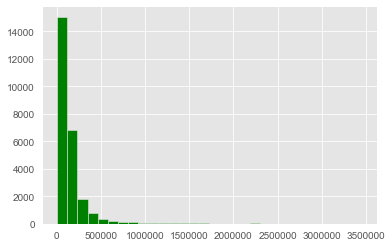

In [10]:
plt.hist(df['price'],bins=30, color='green')

In [11]:
corr_mat=df[['price','surface_total','rooms','bedrooms','bathrooms']].corr()
corr_mat

,price,surface_total,rooms,bedrooms,bathrooms
price,1.000000,0.664942,0.430070,0.300356,0.405673
surface_total,0.664942,1.000000,0.604974,0.686146,0.765760
rooms,0.430070,0.604974,1.000000,0.770108,0.429296
bedrooms,0.300356,0.686146,0.770108,1.000000,0.678597
bathrooms,0.405673,0.765760,0.429296,0.678597,1.000000


Text(0.5, 1, 'Correlation Matrix')

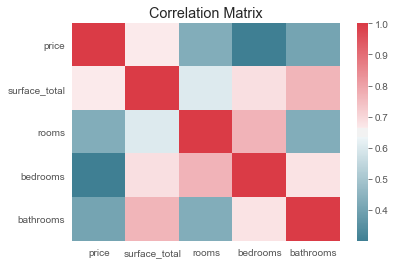

In [12]:
sns.heatmap(corr_mat,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

### Model 1 - Linear Regression raw data only numerical variables

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
train_colombia,test_colombia=train_test_split(df_colombia,test_size=0.2,random_state=42)
train_argentina,test_argentina=train_test_split(df_argentina,test_size=0.2,random_state=42)

In [86]:
predictive_cols=['surface_total','rooms','bedrooms','bathrooms']

x=train_colombia[predictive_cols]
y=train_colombia['price']

In [87]:
linear_model=LinearRegression()
linear_model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
linear_model.score(x,y)

0.672569266131951

Use only the numerical variables is not enough, but is a good start

### Dummies for categorical variables

In [89]:
df_colombia.provincia_departamento.unique()

array(['Atlántico', 'Valle del Cauca', 'Santander', 'Cundinamarca',
       'Risaralda', 'Antioquia', 'Bolívar', 'Huila', 'Norte de Santander',
       'Quindío', 'Magdalena', 'Córdoba', 'Tolima', 'Boyacá', 'Meta',
       'Cauca'], dtype=object)

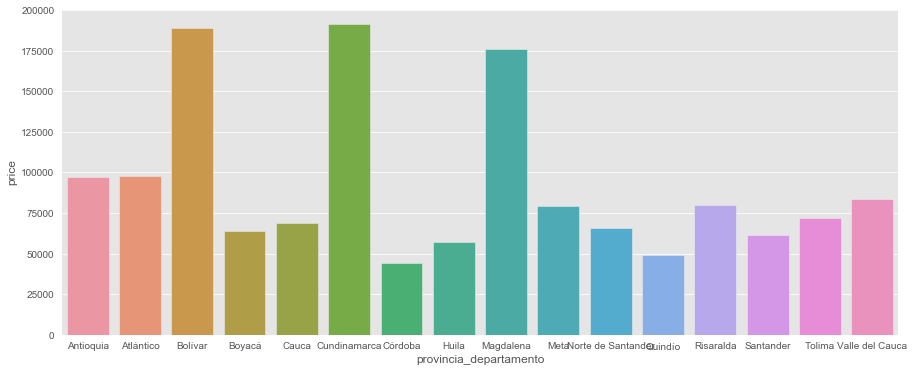

In [90]:
departamento_colombia=df_colombia.groupby('provincia_departamento')['price'].mean()
departamento_colombia=pd.DataFrame(departamento_colombia).reset_index()
plt.figure(figsize=(15,6))
sns.barplot(x='provincia_departamento',y='price',data=departamento_colombia)

In [91]:
df_colombia.ciudad.unique()

array(['Barranquilla', 'Cali', 'Floridablanca', 'Bogotá D.C', 'Pereira',
       'Envigado', 'Medellín', 'Sabaneta', 'Cartagena', 'Bello',
       'Palermo', 'Gachancipá', 'Funza', 'La Estrella', 'Itagui',
       'Jamundí', 'Chía', 'Bucaramanga', 'Madrid', 'Rionegro',
       'Los Patios', 'Puerto Colombia', 'Neiva', 'Cabrera', 'Ricaurte',
       'Soacha', 'Soledad', 'Armenia', 'Villa del Rosario', 'Santa Marta',
       'Cajicá', 'Copacabana', 'Zipaquirá', 'Palmira', 'Mosquera',
       'La Vega', 'Agua de Dios', 'Abejorral', 'Guarne', 'Tabio',
       'Marinilla', 'Pueblo Nuevo', 'Girardot', 'Ibagué',
       'Santafé de Antioquia', 'Yumbo', 'Chiquinquirá',
       'Santa Rosa de Cabal', 'Marsella', 'Tunja', 'La Calera', 'Cota',
       'Retiro', 'San Martín', 'La Ceja', 'Piedecuesta', 'Sopó', 'Tuluá',
       'Girón', 'Buenaventura', 'Juan de Acosta', 'Barrancabermeja',
       'Tocancipá', 'Barbosa', 'El Carmen de Viboral', 'Girardota',
       'Melgar', 'Duitama', 'Fusagasugá', 'Anapoima', 'S

[Text(0, 0, 'Abejorral'),
 Text(0, 0, 'Acacías'),
 Text(0, 0, 'Agua de Dios'),
 Text(0, 0, 'Anapoima'),
 Text(0, 0, 'Armenia'),
 Text(0, 0, 'Barbosa'),
 Text(0, 0, 'Barrancabermeja'),
 Text(0, 0, 'Barranquilla'),
 Text(0, 0, 'Bello'),
 Text(0, 0, 'Bogotá D.C'),
 Text(0, 0, 'Bucaramanga'),
 Text(0, 0, 'Buenaventura'),
 Text(0, 0, 'Cabrera'),
 Text(0, 0, 'Cajicá'),
 Text(0, 0, 'Cali'),
 Text(0, 0, 'Cartagena'),
 Text(0, 0, 'Chiquinquirá'),
 Text(0, 0, 'Chía'),
 Text(0, 0, 'Copacabana'),
 Text(0, 0, 'Cota'),
 Text(0, 0, 'Curití'),
 Text(0, 0, 'Duitama'),
 Text(0, 0, 'El Carmen de Viboral'),
 Text(0, 0, 'Envigado'),
 Text(0, 0, 'Floridablanca'),
 Text(0, 0, 'Funza'),
 Text(0, 0, 'Fusagasugá'),
 Text(0, 0, 'Gachancipá'),
 Text(0, 0, 'Girardot'),
 Text(0, 0, 'Girardota'),
 Text(0, 0, 'Girón'),
 Text(0, 0, 'Guarne'),
 Text(0, 0, 'Ibagué'),
 Text(0, 0, 'Itagui'),
 Text(0, 0, 'Jamundí'),
 Text(0, 0, 'Juan de Acosta'),
 Text(0, 0, 'La Calera'),
 Text(0, 0, 'La Ceja'),
 Text(0, 0, 'La Estrella'),

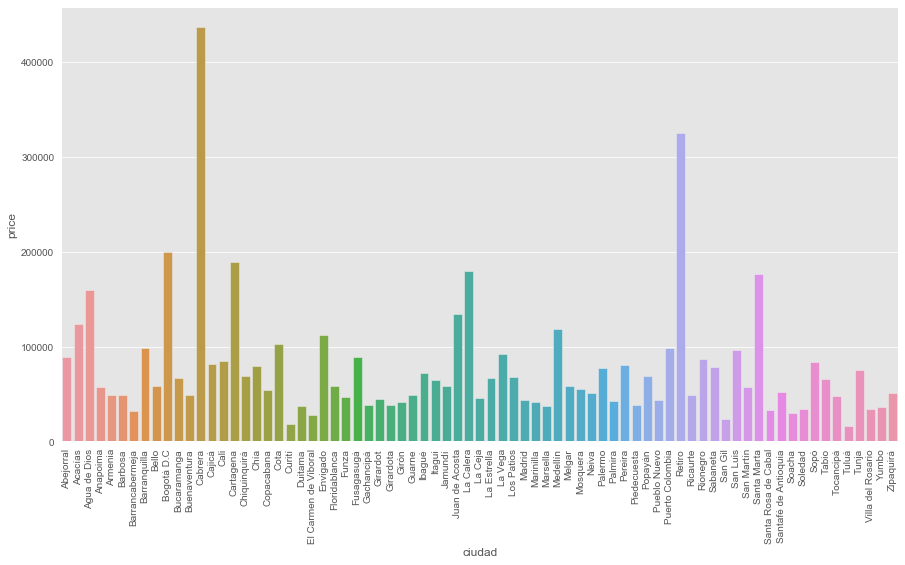

In [92]:
ciudad_colombia=df_colombia.groupby('ciudad')['price'].mean()
ciudad_colombia=pd.DataFrame(ciudad_colombia).reset_index()
plt.figure(figsize=(15,8))
ax=sns.barplot(x='ciudad',y='price',data=ciudad_colombia)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [93]:
df_argentina.provincia_departamento.unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Bs.As. G.B.A. Zona Norte', 'Buenos Aires Costa Atlántica',
       'Neuquén', 'Bs.As. G.B.A. Zona Oeste', 'Córdoba', 'Santa Fe',
       'Buenos Aires Interior', 'Río Negro', 'Mendoza', 'Entre Ríos',
       'Salta', 'Misiones', 'Chubut', 'San Luis', 'Chaco', 'Tucumán',
       'Jujuy', 'San Juan'], dtype=object)

[Text(0, 0, 'Bs.As. G.B.A. Zona Norte'),
 Text(0, 0, 'Bs.As. G.B.A. Zona Oeste'),
 Text(0, 0, 'Bs.As. G.B.A. Zona Sur'),
 Text(0, 0, 'Buenos Aires Costa Atlántica'),
 Text(0, 0, 'Buenos Aires Interior'),
 Text(0, 0, 'Capital Federal'),
 Text(0, 0, 'Chaco'),
 Text(0, 0, 'Chubut'),
 Text(0, 0, 'Córdoba'),
 Text(0, 0, 'Entre Ríos'),
 Text(0, 0, 'Jujuy'),
 Text(0, 0, 'Mendoza'),
 Text(0, 0, 'Misiones'),
 Text(0, 0, 'Neuquén'),
 Text(0, 0, 'Río Negro'),
 Text(0, 0, 'Salta'),
 Text(0, 0, 'San Juan'),
 Text(0, 0, 'San Luis'),
 Text(0, 0, 'Santa Fe'),
 Text(0, 0, 'Tucumán')]

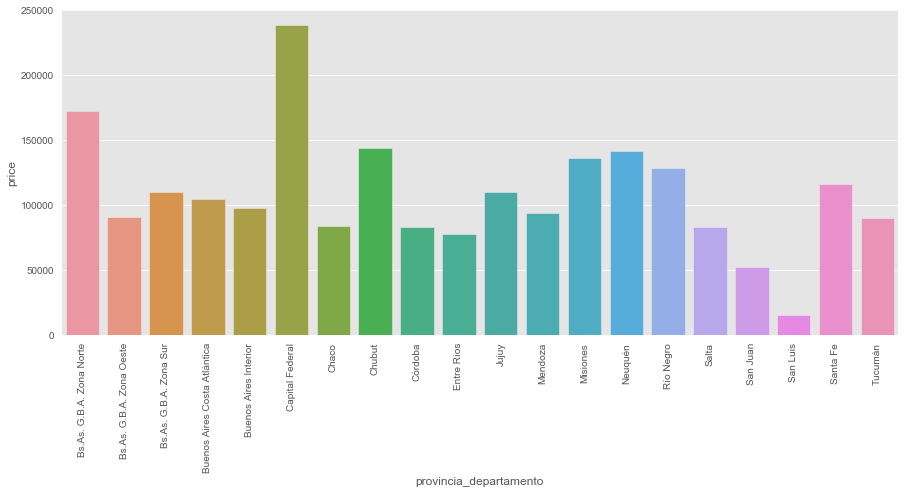

In [94]:
departamento_argentina=df_argentina.groupby('provincia_departamento')['price'].mean()
departamento_argentina=pd.DataFrame(departamento_argentina).reset_index()
plt.figure(figsize=(15,6))
ax=sns.barplot(x='provincia_departamento',y='price',data=departamento_argentina)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [95]:
df_argentina.ciudad.unique()

array(['Villa Crespo', 'Palermo', 'Balvanera', 'La Plata', 'Tigre',
       'Almagro', 'Caballito', 'Monte Hermoso', 'Recoleta',
       'Mar del Plata', 'Belgrano', 'Necochea', 'Confluencia',
       'San Telmo', 'Pinamar', 'Ituzaingó', 'Córdoba', 'Neuquén',
       'Colegiales', 'Villa Gesell', 'Rosario', 'Barrio Norte',
       'Chacarita', 'San Miguel', 'Villa Urquiza', 'Lomas de Zamora',
       'San Lorenzo', 'Villa Luro', 'Morón', 'Quilmes',
       'Parque Chacabuco', 'Constitución', 'Avellaneda', 'Pilar',
       'Monserrat', 'Congreso', 'Tres de Febrero', 'Puerto Madero',
       'Liniers', 'Bahía Blanca', 'San Carlos de Bariloche', 'Junín',
       'Mataderos', 'Villa Santa Rita', 'Moreno', 'San Nicolás', 'Once',
       'San Isidro', 'Vicente López', 'La Matanza', 'Villa Devoto',
       'General San Martín', 'Boca', 'Floresta', 'Centro / Microcentro',
       'General Roca', 'Punilla', 'Villa Lugano', 'Las Cañitas',
       'Mendoza', 'Villa Ortuzar', 'Pompeya', 'Villa del Parque',
    

In [96]:
categories=["provincia_departamento"]


cat_dummies=pd.get_dummies(df_colombia["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia.join(cat_dummies)
df_colombia=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina.join(cat_dummies)
df_argentina=df_train_new

In [97]:
categories=["provincia_departamento"]


cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

### Model 2 - Linear Regression using categorical variables

#### Colombia

In [98]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [99]:
linear_model=LinearRegression()
linear_model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
linear_model.score(x_test,y_test)

0.7113676605383421

In [101]:
preds=linear_model.predict(x_test)

In [102]:
preds=abs(preds)

In [103]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,preds))
print("RMSLE: %f" % (rmsle))

RMSE: 72139.756486
RMSLE: 0.620367


In [104]:
df_colombia.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'price', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca'], dtype=object)

In [105]:
df_test_colombia.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Cundinamarca', 'departamento_Magdalena',
       'departamento_Norte de Santander', 'departamento_Quindío',
       'departamento_Risaralda', 'departamento_Santander',
       'departamento_Tolima', 'departamento_Valle del Cauca'],
      dtype=object)

Linear Regression doesn't seem to be enough

### Model 3 - XGBoost

#### Colombia

In [106]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [107]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [108]:
xg_reg_col = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

In [109]:
xg_reg_col.fit(x_train,y_train)

preds = xg_reg_col.predict(x_test)

In [110]:
df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [111]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 61183.882219
RMSLE: 0.271998


#### Now I use this model to predict the price on the Test.csv

In [112]:
df_test_colombia['departamento_Bolívar']=0
df_test_colombia['departamento_Boyacá']=0
df_test_colombia['departamento_Cauca']=0
df_test_colombia['departamento_Córdoba']=0
df_test_colombia['departamento_Huila']=0
df_test_colombia['departamento_Meta']=0
df_test_colombia['departamento_Quindío']=0


predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x_test=df_test_colombia[predictive_cols]

In [113]:
predictions=xg_reg_col.predict(x_test)

In [114]:
df_test_colombia['Predictions']=predictions

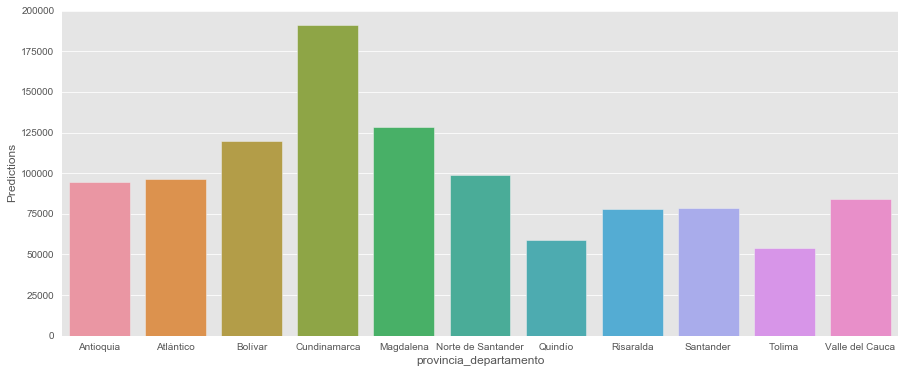

In [115]:
departamento_colombia=df_test_colombia.groupby('provincia_departamento')['Predictions'].mean()
departamento_colombia=pd.DataFrame(departamento_colombia).reset_index()
plt.figure(figsize=(15,6))
sns.barplot(x='provincia_departamento',y='Predictions',data=departamento_colombia)

In [116]:
df_predictions_colombia=df_test_colombia[['Id','Predictions']]
df_predictions_colombia.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Colombia_predictions.csv',index=None)

#### Argentina

In [117]:
df_argentina.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'price',
       'departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Chaco',
       'departamento_Chubut', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Jujuy',
       'departamento_Mendoza', 'departamento_Misiones',
       'departamento_Neuquén', 'departamento_Río Negro',
       'departamento_Salta', 'departamento_San Juan',
       'departamento_San Luis', 'departamento_Santa Fe',
       'departamento_Tucumán'], dtype=object)

In [118]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Chaco',
       'departamento_Chubut', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Jujuy',
       'departamento_Mendoza', 'departamento_Misiones',
       'departamento_Neuquén', 'departamento_Río Negro',
       'departamento_Salta', 'departamento_San Juan',
       'departamento_San Luis', 'departamento_Santa Fe',
       'departamento_Tucumán']

x=df_argentina[predictive_cols]
y=df_argentina['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [119]:
xg_reg_arg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

In [120]:
xg_reg_arg.fit(x_train,y_train)

preds = xg_reg_arg.predict(x_test)

In [121]:
df_preds_arg=pd.DataFrame(preds,columns=["Prediction"])
#df_preds_arg['Prediction']=abs(df_preds['Prediction'])

In [122]:
rmse = np.sqrt(mean_squared_error(y_test, df_preds_arg))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_preds_arg))
print("RMSLE: %f" % (rmsle))

RMSE: 97857.659412
RMSLE: 0.306241


#### Now I use this model to predict the price on the Test.csv

In [123]:
df_test_argentina['departamento_Tucumán']=0
df_test_argentina['departamento_Chaco']=0
df_test_argentina['departamento_Jujuy']=0
df_test_argentina['departamento_Chubut']=0

predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Chaco',
       'departamento_Chubut', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Jujuy',
       'departamento_Mendoza', 'departamento_Misiones',
       'departamento_Neuquén', 'departamento_Río Negro',
       'departamento_Salta', 'departamento_San Juan',
       'departamento_San Luis', 'departamento_Santa Fe',
       'departamento_Tucumán']

x_test=df_test_argentina[predictive_cols]

In [124]:
predictions=xg_reg_arg.predict(x_test)

In [125]:
df_test_argentina['Predictions']=predictions

[Text(0, 0, 'Bs.As. G.B.A. Zona Norte'),
 Text(0, 0, 'Bs.As. G.B.A. Zona Oeste'),
 Text(0, 0, 'Bs.As. G.B.A. Zona Sur'),
 Text(0, 0, 'Buenos Aires Costa Atlántica'),
 Text(0, 0, 'Buenos Aires Interior'),
 Text(0, 0, 'Capital Federal'),
 Text(0, 0, 'Corrientes'),
 Text(0, 0, 'Córdoba'),
 Text(0, 0, 'Entre Ríos'),
 Text(0, 0, 'Mendoza'),
 Text(0, 0, 'Misiones'),
 Text(0, 0, 'Neuquén'),
 Text(0, 0, 'Río Negro'),
 Text(0, 0, 'Salta'),
 Text(0, 0, 'San Juan'),
 Text(0, 0, 'San Luis'),
 Text(0, 0, 'Santa Fe')]

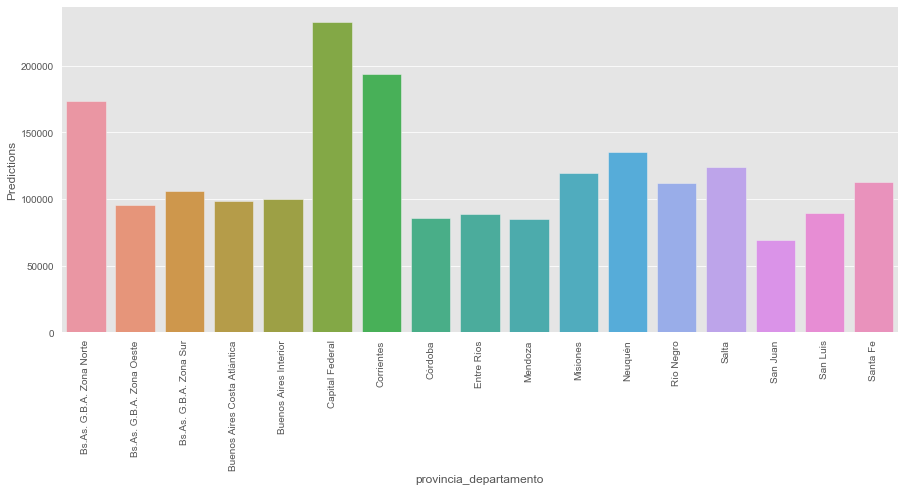

In [126]:
departamento_argentina=df_test_argentina.groupby('provincia_departamento')['Predictions'].mean()
departamento_argentina=pd.DataFrame(departamento_argentina).reset_index()
plt.figure(figsize=(15,6))
ax=sns.barplot(x='provincia_departamento',y='Predictions',data=departamento_argentina)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [127]:
df_predictions_argentina=df_test_argentina[['Id','Predictions']]
df_predictions_argentina.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Argentina_predictions.csv',index=None)

Combining files of predictions for Colombia and Argentina I get to my final prediction file

### Model 4 - XGBoost with only states form test file

In [128]:
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [129]:
df_test_colombia['provincia_departamento'].unique()

array(['Cundinamarca', 'Antioquia', 'Atlántico', 'Valle del Cauca',
       'Santander', 'Risaralda', 'Tolima', 'Quindío',
       'Norte de Santander', 'Bolívar', 'Magdalena'], dtype=object)

In [130]:
df_colombia_filter_states=df_colombia[(df_colombia['provincia_departamento']=='Cundinamarca') | (df_colombia['provincia_departamento']=='Antioquia')| (df_colombia['provincia_departamento']=='Atlántico')| (df_colombia['provincia_departamento']=='Valle del Cauca')| (df_colombia['provincia_departamento']=='Santander')| (df_colombia['provincia_departamento']=='Risaralda')| (df_colombia['provincia_departamento']=='Tolima')| (df_colombia['provincia_departamento']=='Quindío')| (df_colombia['provincia_departamento']=='Norte de Santander')| (df_colombia['provincia_departamento']=='Bolívar')| (df_colombia['provincia_departamento']=='Magdalena')]


In [131]:
df_test_argentina['provincia_departamento'].unique()

array(['Santa Fe', 'Capital Federal', 'Buenos Aires Costa Atlántica',
       'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste',
       'Bs.As. G.B.A. Zona Sur', 'Córdoba', 'Río Negro', 'Neuquén',
       'Buenos Aires Interior', 'Salta', 'Mendoza', 'Misiones',
       'Corrientes', 'San Juan', 'Entre Ríos', 'San Luis'], dtype=object)

In [132]:
df_argentina_filter_states=df_argentina[(df_argentina['provincia_departamento']=='Santa Fe') | (df_argentina['provincia_departamento']=='Capital Federal') | (df_argentina['provincia_departamento']=='Buenos Aires Costa Atlántica') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Norte') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Oeste') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Sur') | (df_argentina['provincia_departamento']=='Córdoba') | (df_argentina['provincia_departamento']=='Río Negro') | (df_argentina['provincia_departamento']=='Neuquén') | (df_argentina['provincia_departamento']=='Buenos Aires Interior') | (df_argentina['provincia_departamento']=='Salta') | (df_argentina['provincia_departamento']=='Mendoza') | (df_argentina['provincia_departamento']=='Misiones') | (df_argentina['provincia_departamento']=='Corrientes') | (df_argentina['provincia_departamento']=='San Juan') | (df_argentina['provincia_departamento']=='Entre Ríos') | (df_argentina['provincia_departamento']=='San Luis')]

In [133]:
categories=["provincia_departamento"]


cat_dummies=pd.get_dummies(df_colombia_filter_states["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia_filter_states.join(cat_dummies)
df_colombia_filter_states=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina_filter_states["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina_filter_states.join(cat_dummies)
df_argentina_filter_states=df_train_new


cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

#### Colombia

In [134]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Cundinamarca', 'departamento_Magdalena',
       'departamento_Norte de Santander', 'departamento_Quindío',
       'departamento_Risaralda', 'departamento_Santander',
       'departamento_Tolima', 'departamento_Valle del Cauca']

x=df_colombia_filter_states[predictive_cols]
y=df_colombia_filter_states['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [135]:
xg_reg_col = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

xg_reg_col.fit(x_train,y_train)

preds = xg_reg_col.predict(x_test)

In [136]:
df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [137]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 50755.725286
RMSLE: 0.274283


#### Now I do the predictions

In [138]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Cundinamarca', 'departamento_Magdalena',
       'departamento_Norte de Santander', 'departamento_Quindío',
       'departamento_Risaralda', 'departamento_Santander',
       'departamento_Tolima', 'departamento_Valle del Cauca']

x_test=df_test_colombia[predictive_cols]

In [139]:
predictions=xg_reg_col.predict(x_test)

In [140]:
df_test_colombia['Predictions']=predictions

In [141]:
df_predictions_colombia=df_test_colombia[['Id','Predictions']]
df_predictions_colombia.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Colombia_only_provinces_from_test_predictions.csv',index=None)

#### Argentina

In [142]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Mendoza',
       'departamento_Misiones', 'departamento_Neuquén',
       'departamento_Río Negro', 'departamento_Salta',
       'departamento_San Juan', 'departamento_San Luis',
       'departamento_Santa Fe']

x=df_argentina_filter_states[predictive_cols]
y=df_argentina_filter_states['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [143]:
xg_reg_arg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

xg_reg_arg.fit(x_train,y_train)

preds = xg_reg_arg.predict(x_test)

In [144]:
df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [145]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 99352.106328
RMSLE: 0.302578


#### Now I do the predictions

In [146]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Mendoza',
       'departamento_Misiones', 'departamento_Neuquén',
       'departamento_Río Negro', 'departamento_Salta',
       'departamento_San Juan', 'departamento_San Luis',
       'departamento_Santa Fe']

x_test=df_test_argentina[predictive_cols]

In [147]:
predictions=xg_reg_arg.predict(x_test)

In [148]:
df_test_argentina['Predictions']=predictions

In [149]:
df_predictions_argentina=df_test_argentina[['Id','Predictions']]
df_predictions_argentina.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Argentina_ony_provinces_from_test_predictions.csv',index=None)

#### Combining both files I get the final results submission file

### Model 5 - Linea regression with Box-Cox to price

In [52]:
#read and separate the df
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [53]:
#Dummies
cat_dummies=pd.get_dummies(df_colombia["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia.join(cat_dummies)
df_colombia=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina.join(cat_dummies)
df_argentina=df_train_new

cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([   7707.,   13763.,   15139., ..., 1238646., 1252959., 1475365.])),
 (102717.27568264747, 130420.42917427004, 0.8236747311320102))

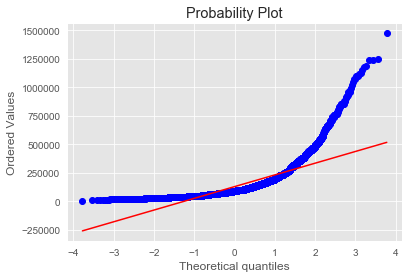

In [54]:
#Check if the price follows a normal distribution
stats.probplot(df_colombia['price'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([   6009.,   10800.,   10900., ..., 3450000., 3450000., 3450000.])),
 (174111.9947446267, 183160.74905280615, 0.6783052107113653))

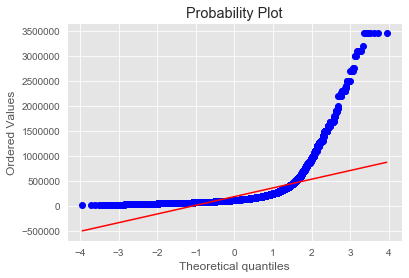

In [55]:
#Check if the price follows a normal distribution
stats.probplot(df_argentina['price'], dist="norm",plot=plt)

In [56]:
price,fitted_lambda_col = stats.boxcox(df_colombia['price'])
box_col=round(fitted_lambda_col,2)
print("Lambda after Box-cox for Colombia is:",box_col)

price,fitted_lambda_arg = stats.boxcox(df_argentina['price'])
box_arg=round(fitted_lambda_arg,2)
print("Lambda after Box-cox for Argentina is:",box_arg)

Lambda after Box-cox for Colombia is: -0.24
Lambda after Box-cox for Argentina is: -0.41


In [57]:
df_colombia['box_price']=boxcox(df_colombia['price'],fitted_lambda_col)
df_argentina['box_price']=boxcox(df_argentina['price'],fitted_lambda_arg)

((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([3.63150666, 3.69212147, 3.70128601, ..., 3.95763684, 3.95800837,
         3.96318076])),
 (0.04225406379344342, 3.840069218062945, 0.998976482051504))

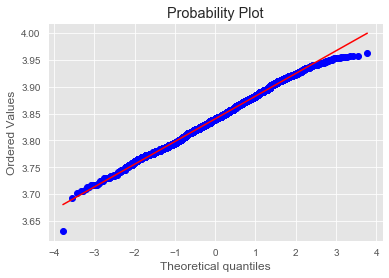

In [58]:
#Check if the price follows a normal distribution
stats.probplot(df_colombia['box_price'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([2.34743942, 2.36157742, 2.36177339, ..., 2.40827104, 2.40827104,
         2.40827104])),
 (0.005189111873788965, 2.393666518763282, 0.9944283644567454))

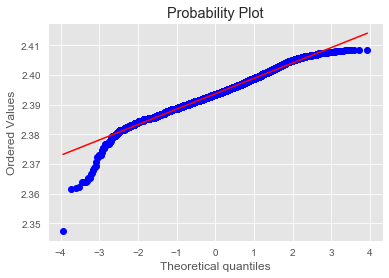

In [59]:
#Check if the price follows a normal distribution
stats.probplot(df_argentina['box_price'], dist="norm",plot=plt)

#### Colombia

In [60]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['box_price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

linear_model_col=LinearRegression()
linear_model_col.fit(x_train,y_train)

linear_model_col.score(x_test,y_test)

0.7636673051358988

In [61]:
preds=linear_model_col.predict(x_test)
#preds=abs(preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,preds))
print("RMSLE: %f" % (rmsle))

RMSE: 0.020752
RMSLE: 0.004293


In [62]:
y_test_inv=inv_boxcox(y_test,fitted_lambda_col)
preds_inv=inv_boxcox(preds,fitted_lambda_col)

rmsle=np.sqrt(mean_squared_log_error(y_test_inv,preds_inv))
print("RMSLE: %f" % (rmsle))

RMSLE: 0.354936


#### Argentina

In [45]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total','departamento_Bs.As. G.B.A. Zona Norte',
       'departamento_Bs.As. G.B.A. Zona Oeste',
       'departamento_Bs.As. G.B.A. Zona Sur',
       'departamento_Buenos Aires Costa Atlántica',
       'departamento_Buenos Aires Interior',
       'departamento_Capital Federal', 'departamento_Córdoba',
       'departamento_Entre Ríos', 'departamento_Mendoza',
       'departamento_Misiones', 'departamento_Neuquén',
       'departamento_Río Negro', 'departamento_Salta',
       'departamento_San Juan', 'departamento_San Luis',
       'departamento_Santa Fe']

x=df_argentina[predictive_cols]
y=df_argentina['box_price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

linear_model_arg=LinearRegression()
linear_model_arg.fit(x_train,y_train)

linear_model_arg.score(x_test,y_test)

0.6690967266230761

In [46]:
preds=linear_model_arg.predict(x_test)
preds=abs(preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,preds))
print("RMSLE: %f" % (rmsle))

RMSE: 0.002972
RMSLE: 0.000876


In [49]:
y_test_inv=inv_boxcox(y_test,fitted_lambda_arg)
preds_inv=inv_boxcox(preds,fitted_lambda_arg)


In [64]:
list(y_test_inv)

[41287.999999999935,
 220203.99999999927,
 49546.0000000001,
 170658.00000000055,
 82575.99999999972,
 50921.99999999979,
 123864.99999999949,
 214698.99999999968,
 189925.99999999965,
 31653.99999999998,
 265620.9999999989,
 743187.0000000012,
 41287.999999999935,
 41287.999999999935,
 99092.0000000004,
 45417.0000000002,
 74318.99999999997,
 57803.00000000021,
 99092.0000000004,
 118358.99999999987,
 165152.99999999962,
 44040.99999999991,
 406000.9999999978,
 88080.9999999999,
 104596.99999999977,
 81007.0000000003,
 412881.99999999924,
 71566.00000000013,
 66061.00000000017,
 156894.9999999997,
 167904.99999999994,
 330306.00000000047,
 79824.00000000007,
 85329.00000000012,
 27525.000000000076,
 37435.0,
 178914.99999999892,
 179190.99999999927,
 66061.00000000017,
 88080.9999999999,
 110101.99999999983,
 38536.00000000017,
 178914.99999999892,
 49546.0000000001,
 82575.99999999972,
 55051.00000000001,
 58353.99999999974,
 123864.99999999949,
 63309.00000000008,
 151389.9999999995

In [67]:
y_test_inv

13380     41288.0
6881     220204.0
7763      49546.0
20780    170658.0
2955      82576.0
           ...   
15136     60556.0
10941    156895.0
7420      85329.0
19607    110102.0
20133     99092.0
Name: box_price, Length: 1754, dtype: float64

#### This is not enough yet

### Model 6 - XGBoost with boxcox

In [164]:
#read and separate the df
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [165]:
#Dummies
cat_dummies=pd.get_dummies(df_colombia["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia.join(cat_dummies)
df_colombia=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina.join(cat_dummies)
df_argentina=df_train_new

cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

In [166]:
price,fitted_lambda_col = stats.boxcox(df_colombia['price'])
box_col=round(fitted_lambda_col,2)
print("Lambda after Box-cox for Colombia is:",box_col)

price,fitted_lambda_arg = stats.boxcox(df_argentina['price'])
box_arg=round(fitted_lambda_arg,2)
print("Lambda after Box-cox for Argentina is:",box_arg)

df_colombia['box_price']=boxcox(df_colombia['price'],fitted_lambda_col)
df_argentina['box_price']=boxcox(df_argentina['price'],fitted_lambda_arg)

Lambda after Box-cox for Colombia is: -0.24
Lambda after Box-cox for Argentina is: -0.41


#### Colombia

In [167]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total','departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['box_price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [168]:
xg_reg_col = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

xg_reg_col.fit(x_train,y_train)

preds = xg_reg_col.predict(x_test)

In [169]:
df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [170]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 0.016799
RMSLE: 0.003476


In [171]:
y_test_inv=inv_boxcox(y_test,fitted_lambda_col)
preds_inv=inv_boxcox(preds,fitted_lambda_col)

rmsle=np.sqrt(mean_squared_log_error(y_test_inv,preds_inv))
print("RMSLE: %f" % (rmsle))

RMSLE: 0.282603


#### Applying a Boxcox transformation doesn't seem to improve the xgboost

### Model 7 - Random Forest Regressor

In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [173]:
#read and separate the df
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

#Dummies
cat_dummies=pd.get_dummies(df_colombia["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia.join(cat_dummies)
df_colombia=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina.join(cat_dummies)
df_argentina=df_train_new

cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Colombia

In [174]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.05,random_state=42)

In [175]:
forest=RandomForestRegressor(n_jobs=2, oob_score=True, n_estimators=100,random_state=11)
forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=True,
                      random_state=11, verbose=0, warm_start=False)

In [176]:
forest.score(x_test,y_test)

0.8023555447945094

In [177]:
forest.oob_score_

0.7832716214112498

In [178]:
rf = RandomForestRegressor(n_estimators=100,random_state=12)
scores = cross_val_score(rf, x_train, y_train, cv=5)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76509192 0.80288333 0.78417278 0.77800022 0.76413505]
Mean: 0.7788566606495066
Standard Deviation: 0.01423003526416175


In [179]:
preds=forest.predict(x_test)
df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [180]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 66776.533376
RMSLE: 0.289306


In [181]:
#Check for best parameters
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = { "criterion" : ["mse", "mae"], "min_samples_leaf" : [1,15,20], "min_samples_split" : [2,5,10], "n_estimators": [50,100],"max_features":["auto", "sqrt", "log2"]}
rf = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True)
clf = GridSearchCV(estimator=rf, param_grid=param_grid)
clf.fit(x_train, y_train)
clf.best_params_

KeyboardInterrupt: 

### Model 8 - XGBoost with all the data - This is the winner model

In [128]:
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [129]:
categories=["provincia_departamento","ciudad"]

for category in categories:
    cat_dummies=pd.get_dummies(df_colombia[category], prefix=category)
    df_train_new=df_colombia.join(cat_dummies)
    df_colombia=df_train_new

    cat_dummies=pd.get_dummies(df_argentina[category], prefix=category)
    df_train_new=df_argentina.join(cat_dummies)
    df_argentina=df_train_new

for category in categories:
    cat_dummies=pd.get_dummies(df_test_colombia[category], prefix=category)
    df_test_new=df_test_colombia.join(cat_dummies)
    df_test_colombia=df_test_new

    cat_dummies=pd.get_dummies(df_test_argentina[category], prefix=category)
    df_test_new=df_test_argentina.join(cat_dummies)
    df_test_argentina=df_test_new

#### Colombia

In [130]:
predictive_cols=['rooms', 'bathrooms',
       'surface_total','provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'ciudad_Abejorral',
       'ciudad_Acacías', 'ciudad_Agua de Dios', 'ciudad_Anapoima',
       'ciudad_Armenia', 'ciudad_Barbosa', 'ciudad_Barrancabermeja',
       'ciudad_Barranquilla', 'ciudad_Bello', 'ciudad_Bogotá D.C',
       'ciudad_Bucaramanga', 'ciudad_Buenaventura', 'ciudad_Cabrera',
       'ciudad_Cajicá', 'ciudad_Cali', 'ciudad_Cartagena',
       'ciudad_Chiquinquirá', 'ciudad_Chía', 'ciudad_Copacabana',
       'ciudad_Cota', 'ciudad_Curití', 'ciudad_Duitama',
       'ciudad_El Carmen de Viboral', 'ciudad_Envigado',
       'ciudad_Floridablanca', 'ciudad_Funza', 'ciudad_Fusagasugá',
       'ciudad_Gachancipá', 'ciudad_Girardot', 'ciudad_Girardota',
       'ciudad_Girón', 'ciudad_Guarne', 'ciudad_Ibagué', 'ciudad_Itagui',
       'ciudad_Jamundí', 'ciudad_Juan de Acosta', 'ciudad_La Calera',
       'ciudad_La Ceja', 'ciudad_La Estrella', 'ciudad_La Vega',
       'ciudad_Los Patios', 'ciudad_Madrid', 'ciudad_Marinilla',
       'ciudad_Marsella', 'ciudad_Medellín', 'ciudad_Melgar',
       'ciudad_Mosquera', 'ciudad_Neiva', 'ciudad_Palermo',
       'ciudad_Palmira', 'ciudad_Pereira', 'ciudad_Piedecuesta',
       'ciudad_Popayán', 'ciudad_Pueblo Nuevo', 'ciudad_Puerto Colombia',
       'ciudad_Retiro', 'ciudad_Ricaurte', 'ciudad_Rionegro',
       'ciudad_Sabaneta', 'ciudad_San Gil', 'ciudad_San Luis',
       'ciudad_San Martín', 'ciudad_Santa Marta',
       'ciudad_Santa Rosa de Cabal', 'ciudad_Santafé de Antioquia',
       'ciudad_Soacha', 'ciudad_Soledad', 'ciudad_Sopó', 'ciudad_Tabio',
       'ciudad_Tocancipá', 'ciudad_Tuluá', 'ciudad_Tunja',
       'ciudad_Villa del Rosario', 'ciudad_Yumbo', 'ciudad_Zipaquirá']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [131]:
xg_reg_col = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 1, learning_rate = 0.25,
                max_depth = 5, alpha = 2, n_estimators = 90,random_state=42)

xg_reg_col.fit(x_train,y_train)

preds = xg_reg_col.predict(x_test)

df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 49212.195567
RMSLE: 0.255220


#### I do the predictions

In [132]:
df_test_colombia['provincia_departamento_Boyacá']=0
df_test_colombia['provincia_departamento_Cauca']=0
df_test_colombia['provincia_departamento_Córdoba']=0
df_test_colombia['provincia_departamento_Huila']=0
df_test_colombia['provincia_departamento_Meta']=0
df_test_colombia['provincia_departamento_Quindío']=0


categories=['ciudad_Curití', 'ciudad_Cota', 'ciudad_Popayán', 'ciudad_Tabio',
            'ciudad_Retiro', 'ciudad_La Vega', 'ciudad_Tunja', 'ciudad_Duitama',
            'ciudad_Palermo', 'ciudad_Chiquinquirá', 'ciudad_El Carmen de Viboral',
            'ciudad_Tuluá', 'ciudad_Girardota', 'ciudad_Abejorral', 'ciudad_Melgar',
            'ciudad_Acacías', 'ciudad_Villa del Rosario', 'ciudad_Neiva', 'ciudad_Agua de Dios',
            'ciudad_Funza', 'ciudad_Tocancipá', 'ciudad_San Gil', 'ciudad_San Luis',
            'ciudad_Piedecuesta', 'ciudad_San Martín', 'ciudad_Buenaventura', 'ciudad_Barbosa',
            'ciudad_Pueblo Nuevo', 'ciudad_La Calera']

for category in categories:
    df_test_colombia[category]=0

predictive_cols=['rooms', 'bathrooms',
       'surface_total','provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'ciudad_Abejorral',
       'ciudad_Acacías', 'ciudad_Agua de Dios', 'ciudad_Anapoima',
       'ciudad_Armenia', 'ciudad_Barbosa', 'ciudad_Barrancabermeja',
       'ciudad_Barranquilla', 'ciudad_Bello', 'ciudad_Bogotá D.C',
       'ciudad_Bucaramanga', 'ciudad_Buenaventura', 'ciudad_Cabrera',
       'ciudad_Cajicá', 'ciudad_Cali', 'ciudad_Cartagena',
       'ciudad_Chiquinquirá', 'ciudad_Chía', 'ciudad_Copacabana',
       'ciudad_Cota', 'ciudad_Curití', 'ciudad_Duitama',
       'ciudad_El Carmen de Viboral', 'ciudad_Envigado',
       'ciudad_Floridablanca', 'ciudad_Funza', 'ciudad_Fusagasugá',
       'ciudad_Gachancipá', 'ciudad_Girardot', 'ciudad_Girardota',
       'ciudad_Girón', 'ciudad_Guarne', 'ciudad_Ibagué', 'ciudad_Itagui',
       'ciudad_Jamundí', 'ciudad_Juan de Acosta', 'ciudad_La Calera',
       'ciudad_La Ceja', 'ciudad_La Estrella', 'ciudad_La Vega',
       'ciudad_Los Patios', 'ciudad_Madrid', 'ciudad_Marinilla',
       'ciudad_Marsella', 'ciudad_Medellín', 'ciudad_Melgar',
       'ciudad_Mosquera', 'ciudad_Neiva', 'ciudad_Palermo',
       'ciudad_Palmira', 'ciudad_Pereira', 'ciudad_Piedecuesta',
       'ciudad_Popayán', 'ciudad_Pueblo Nuevo', 'ciudad_Puerto Colombia',
       'ciudad_Retiro', 'ciudad_Ricaurte', 'ciudad_Rionegro',
       'ciudad_Sabaneta', 'ciudad_San Gil', 'ciudad_San Luis',
       'ciudad_San Martín', 'ciudad_Santa Marta',
       'ciudad_Santa Rosa de Cabal', 'ciudad_Santafé de Antioquia',
       'ciudad_Soacha', 'ciudad_Soledad', 'ciudad_Sopó', 'ciudad_Tabio',
       'ciudad_Tocancipá', 'ciudad_Tuluá', 'ciudad_Tunja',
       'ciudad_Villa del Rosario', 'ciudad_Yumbo', 'ciudad_Zipaquirá']



x_test=df_test_colombia[predictive_cols]


In [133]:
predictions=xg_reg_col.predict(x_test)

In [134]:
df_test_colombia['Predictions']=predictions

In [135]:
df_predictions_colombia=df_test_colombia[['Id','Predictions']]
df_predictions_colombia.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Colombia_all_data_no_feature_engineering.csv',index=None)

#### Argentina

In [136]:
predictive_cols=['rooms', 'bathrooms',
       'surface_total',
       'provincia_departamento_Bs.As. G.B.A. Zona Norte',
       'provincia_departamento_Bs.As. G.B.A. Zona Oeste',
       'provincia_departamento_Bs.As. G.B.A. Zona Sur',
       'provincia_departamento_Buenos Aires Costa Atlántica',
       'provincia_departamento_Buenos Aires Interior',
       'provincia_departamento_Capital Federal',
       'provincia_departamento_Chaco', 'provincia_departamento_Chubut',
       'provincia_departamento_Córdoba',
       'provincia_departamento_Entre Ríos',
       'provincia_departamento_Jujuy', 'provincia_departamento_Mendoza',
       'provincia_departamento_Misiones',
       'provincia_departamento_Neuquén',
       'provincia_departamento_Río Negro', 'provincia_departamento_Salta',
       'provincia_departamento_San Juan',
       'provincia_departamento_San Luis',
       'provincia_departamento_Santa Fe',
       'provincia_departamento_Tucumán', 'ciudad_Abasto',
       'ciudad_Acambuco', 'ciudad_Agronomía', 'ciudad_Allen',
       'ciudad_Almagro', 'ciudad_Almirante Brown', 'ciudad_Avellaneda',
       'ciudad_Azul', 'ciudad_Añelo', 'ciudad_Bahía Blanca',
       'ciudad_Balcarce', 'ciudad_Balvanera', 'ciudad_Barracas',
       'ciudad_Barrio Norte', 'ciudad_Belgrano', 'ciudad_Berazategui',
       'ciudad_Berisso', 'ciudad_Boca', 'ciudad_Boedo',
       'ciudad_Caballito', 'ciudad_Campana', 'ciudad_Carrodilla',
       'ciudad_Centro / Microcentro', 'ciudad_Chacarita',
       'ciudad_Chacras de Coria', 'ciudad_Cipolletti', 'ciudad_Coghlan',
       'ciudad_Colegiales', 'ciudad_Colón', 'ciudad_Concordia',
       'ciudad_Confluencia', 'ciudad_Congreso', 'ciudad_Constitución',
       'ciudad_Costa del Este', 'ciudad_Córdoba', 'ciudad_Ensenada',
       'ciudad_Escalante', 'ciudad_Escobar', 'ciudad_Esperanza',
       'ciudad_Esteban Echeverría', 'ciudad_Exaltación de la Cruz',
       'ciudad_Ezeiza', 'ciudad_Flores', 'ciudad_Floresta',
       'ciudad_General Belgrano', 'ciudad_General Fernández Oro',
       'ciudad_General Madariaga', 'ciudad_General Pueyrredón',
       'ciudad_General Roca', 'ciudad_General Rodríguez',
       'ciudad_General San Martín', 'ciudad_Godoy Cruz',
       'ciudad_Granadero Baigorria', 'ciudad_Gualeguaychú',
       'ciudad_Hurlingham', 'ciudad_Ituzaingó', 'ciudad_José C Paz',
       'ciudad_Junín', 'ciudad_La Matanza', 'ciudad_La Plata',
       'ciudad_Lanús', 'ciudad_Las Cañitas', 'ciudad_Las Grutas',
       'ciudad_Las Heras', 'ciudad_Liniers', 'ciudad_Lobos',
       'ciudad_Lomas de Zamora', 'ciudad_Luján', 'ciudad_Luján de Cuyo',
       'ciudad_Lácar', 'ciudad_Maipú', 'ciudad_Malargüe',
       'ciudad_Malvinas Argentinas', 'ciudad_Mar Chiquita',
       'ciudad_Mar de Ajó', 'ciudad_Mar del Plata', 'ciudad_Mar del Tuyú',
       'ciudad_Mataderos', 'ciudad_Mendoza', 'ciudad_Mercedes',
       'ciudad_Merlo', 'ciudad_Miramar', 'ciudad_Monserrat',
       'ciudad_Monte Castro', 'ciudad_Monte Hermoso', 'ciudad_Moreno',
       'ciudad_Morón', 'ciudad_Necochea', 'ciudad_Neuquén',
       'ciudad_Nuñez', 'ciudad_Olavarría', 'ciudad_Once',
       'ciudad_Ostende', 'ciudad_Palermo', 'ciudad_Paraná',
       'ciudad_Parque Avellaneda', 'ciudad_Parque Centenario',
       'ciudad_Parque Chacabuco', 'ciudad_Parque Chas',
       'ciudad_Parque Patricios', 'ciudad_Paternal', 'ciudad_Pergamino',
       'ciudad_Pilar', 'ciudad_Pinamar', 'ciudad_Plottier',
       'ciudad_Pompeya', 'ciudad_Posadas', 'ciudad_Puerto Madero',
       'ciudad_Puerto Madryn', 'ciudad_Punilla', 'ciudad_Quilmes',
       'ciudad_Rafaela', 'ciudad_Recoleta', 'ciudad_Resistencia',
       'ciudad_Retiro', 'ciudad_Rincón de los Sauces', 'ciudad_Rivadavia',
       'ciudad_Roldán', 'ciudad_Rosario', 'ciudad_Río Cuarto',
       'ciudad_Río Tercero', 'ciudad_Saavedra', 'ciudad_Salta',
       'ciudad_San Bernardo', 'ciudad_San Carlos de Bariloche',
       'ciudad_San Clemente del Tuyú', 'ciudad_San Cristobal',
       'ciudad_San Fernando', 'ciudad_San Francisco del Monte de Oro',
       'ciudad_San Isidro', 'ciudad_San Juan', 'ciudad_San Lorenzo',
       'ciudad_San Martín de los Andes', 'ciudad_San Miguel',
       'ciudad_San Miguel del Monte', 'ciudad_San Nicolás',
       'ciudad_San Salvador de Jujuy', 'ciudad_San Telmo',
       'ciudad_San Vicente', 'ciudad_Santa Clara del Mar',
       'ciudad_Santa Fe', 'ciudad_Santa Teresita', 'ciudad_Santo Tomé',
       'ciudad_Tandil', 'ciudad_Tigre', 'ciudad_Trelew',
       'ciudad_Tres Arroyos', 'ciudad_Tres de Febrero',
       'ciudad_Tribunales', 'ciudad_Valeria del Mar',
       'ciudad_Velez Sarsfield', 'ciudad_Versalles',
       'ciudad_Vicente López', 'ciudad_Villa Allende',
       'ciudad_Villa Carlos Paz', 'ciudad_Villa Cerro Catedral',
       'ciudad_Villa Constitución', 'ciudad_Villa Crespo',
       'ciudad_Villa Devoto', 'ciudad_Villa General Belgrano',
       'ciudad_Villa General Mitre', 'ciudad_Villa Gesell',
       'ciudad_Villa La Angostura', 'ciudad_Villa Lugano',
       'ciudad_Villa Luro', 'ciudad_Villa María', 'ciudad_Villa Ortuzar',
       'ciudad_Villa Pueyrredón', 'ciudad_Villa Real',
       'ciudad_Villa Riachuelo', 'ciudad_Villa Santa Rita',
       'ciudad_Villa Soldati', 'ciudad_Villa Urquiza',
       'ciudad_Villa del Parque', 'ciudad_Yerba Buena']

x=df_argentina[predictive_cols]
y=df_argentina['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [137]:
xg_reg_arg = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 1, learning_rate = 0.25,
                max_depth = 5, alpha = 2, n_estimators = 500,random_state=42)

xg_reg_arg.fit(x_train,y_train)

preds = xg_reg_arg.predict(x_test)

df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 42030.598315
RMSLE: 0.216998


#### I do the predictions

In [138]:
df_test_argentina['provincia_departamento_Tucumán']=0
df_test_argentina['provincia_departamento_Chaco']=0
df_test_argentina['provincia_departamento_Jujuy']=0
df_test_argentina['provincia_departamento_Chubut']=0


categories=['ciudad_Pompeya', 'ciudad_Carrodilla', 'ciudad_Ensenada',
            'ciudad_Las Heras', 'ciudad_Chacras de Coria', 'ciudad_Junín',
            'ciudad_Villa Allende', 'ciudad_Las Grutas', 'ciudad_Exaltación de la Cruz',
            'ciudad_Azul', 'ciudad_Berisso', 'ciudad_Yerba Buena', 'ciudad_Balcarce', 'ciudad_Necochea',
            'ciudad_Colón', 'ciudad_Villa Soldati', 'ciudad_San Salvador de Jujuy', 'ciudad_Pergamino',
            'ciudad_Villa General Belgrano', 'ciudad_Rivadavia', 'ciudad_Acambuco',
            'ciudad_San Francisco del Monte de Oro', 'ciudad_Río Tercero', 'ciudad_Malargüe', 
            'ciudad_San Miguel del Monte', 'ciudad_Escalante', 'ciudad_Santo Tomé', 'ciudad_Trelew',
            'ciudad_Campana', 'ciudad_Rincón de los Sauces', 'ciudad_General Madariaga', 'ciudad_Concordia',
            'ciudad_Paraná', 'ciudad_Resistencia', 'ciudad_Olavarría', 'ciudad_San Vicente', 'ciudad_Villa María',
            'ciudad_Villa Real', 'ciudad_Puerto Madryn', 'ciudad_Allen', 'ciudad_Roldán', 'ciudad_Santa Clara del Mar',
            'ciudad_Tres Arroyos', 'ciudad_Rafaela', 'ciudad_Villa Riachuelo']

for category in categories:
    df_test_argentina[category]=0

predictive_cols=['rooms', 'bathrooms',
       'surface_total',
       'provincia_departamento_Bs.As. G.B.A. Zona Norte',
       'provincia_departamento_Bs.As. G.B.A. Zona Oeste',
       'provincia_departamento_Bs.As. G.B.A. Zona Sur',
       'provincia_departamento_Buenos Aires Costa Atlántica',
       'provincia_departamento_Buenos Aires Interior',
       'provincia_departamento_Capital Federal',
       'provincia_departamento_Chaco', 'provincia_departamento_Chubut',
       'provincia_departamento_Córdoba',
       'provincia_departamento_Entre Ríos',
       'provincia_departamento_Jujuy', 'provincia_departamento_Mendoza',
       'provincia_departamento_Misiones',
       'provincia_departamento_Neuquén',
       'provincia_departamento_Río Negro', 'provincia_departamento_Salta',
       'provincia_departamento_San Juan',
       'provincia_departamento_San Luis',
       'provincia_departamento_Santa Fe',
       'provincia_departamento_Tucumán', 'ciudad_Abasto',
       'ciudad_Acambuco', 'ciudad_Agronomía', 'ciudad_Allen',
       'ciudad_Almagro', 'ciudad_Almirante Brown', 'ciudad_Avellaneda',
       'ciudad_Azul', 'ciudad_Añelo', 'ciudad_Bahía Blanca',
       'ciudad_Balcarce', 'ciudad_Balvanera', 'ciudad_Barracas',
       'ciudad_Barrio Norte', 'ciudad_Belgrano', 'ciudad_Berazategui',
       'ciudad_Berisso', 'ciudad_Boca', 'ciudad_Boedo',
       'ciudad_Caballito', 'ciudad_Campana', 'ciudad_Carrodilla',
       'ciudad_Centro / Microcentro', 'ciudad_Chacarita',
       'ciudad_Chacras de Coria', 'ciudad_Cipolletti', 'ciudad_Coghlan',
       'ciudad_Colegiales', 'ciudad_Colón', 'ciudad_Concordia',
       'ciudad_Confluencia', 'ciudad_Congreso', 'ciudad_Constitución',
       'ciudad_Costa del Este', 'ciudad_Córdoba', 'ciudad_Ensenada',
       'ciudad_Escalante', 'ciudad_Escobar', 'ciudad_Esperanza',
       'ciudad_Esteban Echeverría', 'ciudad_Exaltación de la Cruz',
       'ciudad_Ezeiza', 'ciudad_Flores', 'ciudad_Floresta',
       'ciudad_General Belgrano', 'ciudad_General Fernández Oro',
       'ciudad_General Madariaga', 'ciudad_General Pueyrredón',
       'ciudad_General Roca', 'ciudad_General Rodríguez',
       'ciudad_General San Martín', 'ciudad_Godoy Cruz',
       'ciudad_Granadero Baigorria', 'ciudad_Gualeguaychú',
       'ciudad_Hurlingham', 'ciudad_Ituzaingó', 'ciudad_José C Paz',
       'ciudad_Junín', 'ciudad_La Matanza', 'ciudad_La Plata',
       'ciudad_Lanús', 'ciudad_Las Cañitas', 'ciudad_Las Grutas',
       'ciudad_Las Heras', 'ciudad_Liniers', 'ciudad_Lobos',
       'ciudad_Lomas de Zamora', 'ciudad_Luján', 'ciudad_Luján de Cuyo',
       'ciudad_Lácar', 'ciudad_Maipú', 'ciudad_Malargüe',
       'ciudad_Malvinas Argentinas', 'ciudad_Mar Chiquita',
       'ciudad_Mar de Ajó', 'ciudad_Mar del Plata', 'ciudad_Mar del Tuyú',
       'ciudad_Mataderos', 'ciudad_Mendoza', 'ciudad_Mercedes',
       'ciudad_Merlo', 'ciudad_Miramar', 'ciudad_Monserrat',
       'ciudad_Monte Castro', 'ciudad_Monte Hermoso', 'ciudad_Moreno',
       'ciudad_Morón', 'ciudad_Necochea', 'ciudad_Neuquén',
       'ciudad_Nuñez', 'ciudad_Olavarría', 'ciudad_Once',
       'ciudad_Ostende', 'ciudad_Palermo', 'ciudad_Paraná',
       'ciudad_Parque Avellaneda', 'ciudad_Parque Centenario',
       'ciudad_Parque Chacabuco', 'ciudad_Parque Chas',
       'ciudad_Parque Patricios', 'ciudad_Paternal', 'ciudad_Pergamino',
       'ciudad_Pilar', 'ciudad_Pinamar', 'ciudad_Plottier',
       'ciudad_Pompeya', 'ciudad_Posadas', 'ciudad_Puerto Madero',
       'ciudad_Puerto Madryn', 'ciudad_Punilla', 'ciudad_Quilmes',
       'ciudad_Rafaela', 'ciudad_Recoleta', 'ciudad_Resistencia',
       'ciudad_Retiro', 'ciudad_Rincón de los Sauces', 'ciudad_Rivadavia',
       'ciudad_Roldán', 'ciudad_Rosario', 'ciudad_Río Cuarto',
       'ciudad_Río Tercero', 'ciudad_Saavedra', 'ciudad_Salta',
       'ciudad_San Bernardo', 'ciudad_San Carlos de Bariloche',
       'ciudad_San Clemente del Tuyú', 'ciudad_San Cristobal',
       'ciudad_San Fernando', 'ciudad_San Francisco del Monte de Oro',
       'ciudad_San Isidro', 'ciudad_San Juan', 'ciudad_San Lorenzo',
       'ciudad_San Martín de los Andes', 'ciudad_San Miguel',
       'ciudad_San Miguel del Monte', 'ciudad_San Nicolás',
       'ciudad_San Salvador de Jujuy', 'ciudad_San Telmo',
       'ciudad_San Vicente', 'ciudad_Santa Clara del Mar',
       'ciudad_Santa Fe', 'ciudad_Santa Teresita', 'ciudad_Santo Tomé',
       'ciudad_Tandil', 'ciudad_Tigre', 'ciudad_Trelew',
       'ciudad_Tres Arroyos', 'ciudad_Tres de Febrero',
       'ciudad_Tribunales', 'ciudad_Valeria del Mar',
       'ciudad_Velez Sarsfield', 'ciudad_Versalles',
       'ciudad_Vicente López', 'ciudad_Villa Allende',
       'ciudad_Villa Carlos Paz', 'ciudad_Villa Cerro Catedral',
       'ciudad_Villa Constitución', 'ciudad_Villa Crespo',
       'ciudad_Villa Devoto', 'ciudad_Villa General Belgrano',
       'ciudad_Villa General Mitre', 'ciudad_Villa Gesell',
       'ciudad_Villa La Angostura', 'ciudad_Villa Lugano',
       'ciudad_Villa Luro', 'ciudad_Villa María', 'ciudad_Villa Ortuzar',
       'ciudad_Villa Pueyrredón', 'ciudad_Villa Real',
       'ciudad_Villa Riachuelo', 'ciudad_Villa Santa Rita',
       'ciudad_Villa Soldati', 'ciudad_Villa Urquiza',
       'ciudad_Villa del Parque', 'ciudad_Yerba Buena']

x_test=df_test_argentina[predictive_cols]

In [139]:
predictions=xg_reg_arg.predict(x_test)

In [140]:
df_test_argentina['Predictions']=predictions

In [141]:
df_predictions_argentina=df_test_argentina[['Id','Predictions']]
df_predictions_argentina.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Argentina_all_data_no_feature_engineering.csv',index=None)

#### Grid Search

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
estimator = xgb.XGBRegressor(
    objective= 'reg:tweedie',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 5, 10),
    'n_estimators': range(70, 150, 300),
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_log_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [84]:
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   37.2s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
      

In [85]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=70, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:tweedie', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Model 9 - Feature Engineering for XGBoost

In [148]:
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#df_colombia=df_colombia[(df_colombia['provincia_departamento']=='Cundinamarca') | (df_colombia['provincia_departamento']=='Antioquia')| (df_colombia['provincia_departamento']=='Atlántico')| (df_colombia['provincia_departamento']=='Valle del Cauca')| (df_colombia['provincia_departamento']=='Santander')| (df_colombia['provincia_departamento']=='Risaralda')| (df_colombia['provincia_departamento']=='Tolima')| (df_colombia['provincia_departamento']=='Quindío')| (df_colombia['provincia_departamento']=='Norte de Santander')| (df_colombia['provincia_departamento']=='Bolívar')| (df_colombia['provincia_departamento']=='Magdalena')]
#df_argentina=df_argentina[(df_argentina['provincia_departamento']=='Santa Fe') | (df_argentina['provincia_departamento']=='Capital Federal') | (df_argentina['provincia_departamento']=='Buenos Aires Costa Atlántica') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Norte') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Oeste') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Sur') | (df_argentina['provincia_departamento']=='Córdoba') | (df_argentina['provincia_departamento']=='Río Negro') | (df_argentina['provincia_departamento']=='Neuquén') | (df_argentina['provincia_departamento']=='Buenos Aires Interior') | (df_argentina['provincia_departamento']=='Salta') | (df_argentina['provincia_departamento']=='Mendoza') | (df_argentina['provincia_departamento']=='Misiones') | (df_argentina['provincia_departamento']=='Corrientes') | (df_argentina['provincia_departamento']=='San Juan') | (df_argentina['provincia_departamento']=='Entre Ríos') | (df_argentina['provincia_departamento']=='San Luis')]

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

categories=["provincia_departamento"]

for category in categories:
    cat_dummies=pd.get_dummies(df_colombia[category], prefix=category)
    df_train_new=df_colombia.join(cat_dummies)
    df_colombia=df_train_new

    cat_dummies=pd.get_dummies(df_argentina[category], prefix=category)
    df_train_new=df_argentina.join(cat_dummies)
    df_argentina=df_train_new

for category in categories:
    cat_dummies=pd.get_dummies(df_test_colombia[category], prefix=category)
    df_test_new=df_test_colombia.join(cat_dummies)
    df_test_colombia=df_test_new

    cat_dummies=pd.get_dummies(df_test_argentina[category], prefix=category)
    df_test_new=df_test_argentina.join(cat_dummies)
    df_test_argentina=df_test_new

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [149]:
df_argentina['extra_rooms']=df_argentina['rooms']-df_argentina['bedrooms']
df_test_argentina['extra_rooms']=df_test_argentina['rooms']-df_test_argentina['bedrooms']

In [150]:
df_colombia['social_bathroom']=((df_colombia['bathrooms']-df_colombia['rooms'])>=1).astype(int)
df_test_colombia['social_bathroom']=((df_test_colombia['bathrooms']-df_test_colombia['rooms'])>=1).astype(int)

df_argentina['social_bathroom']=((df_argentina['bathrooms']-df_argentina['rooms'])>=1).astype(int)
df_test_argentina['social_bathroom']=((df_test_argentina['bathrooms']-df_test_argentina['rooms'])>=1).astype(int)

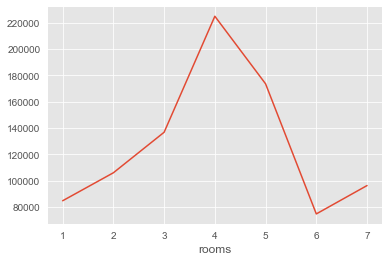

In [151]:
df_colombia.groupby('rooms')['price'].mean().plot()

In [152]:
df_colombia['more_than_4_rooms']=(df_colombia['rooms']>4).astype(int)
df_test_colombia['more_than_4_rooms']=(df_colombia['rooms']>4).astype(int)

In [153]:
df_colombia['touristic_or_capital']=0
df_colombia.loc[df_colombia['ciudad']=="Cartagena",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Santa Marta",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Bogotá D.C",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="La Calera",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Retiro",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Cabrera",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Agua de Dios",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Envigado",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Juan de Acosta",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Medellín",'touristic_or_capital']=1

df_test_colombia['touristic_or_capital']=0
df_test_colombia.loc[df_test_colombia['ciudad']=="Cartagena",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Santa Marta",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Bogotá D.C",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="La Calera",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Retiro",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Cabrera",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Agua de Dios",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Envigado",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Juan de Acosta",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Medellín",'touristic_or_capital']=1

[Text(0, 0, 'Bahía Blanca'),
 Text(0, 0, 'Balvanera'),
 Text(0, 0, 'Barrio Norte'),
 Text(0, 0, 'Belgrano'),
 Text(0, 0, 'Caballito'),
 Text(0, 0, 'Colegiales'),
 Text(0, 0, 'Confluencia'),
 Text(0, 0, 'Córdoba'),
 Text(0, 0, 'Escobar'),
 Text(0, 0, 'Flores'),
 Text(0, 0, 'La Matanza'),
 Text(0, 0, 'Las Cañitas'),
 Text(0, 0, 'Lomas de Zamora'),
 Text(0, 0, 'Mar del Plata'),
 Text(0, 0, 'Monserrat'),
 Text(0, 0, 'Nuñez'),
 Text(0, 0, 'Palermo'),
 Text(0, 0, 'Pilar'),
 Text(0, 0, 'Puerto Madero'),
 Text(0, 0, 'Quilmes'),
 Text(0, 0, 'Recoleta'),
 Text(0, 0, 'Retiro'),
 Text(0, 0, 'Rosario'),
 Text(0, 0, 'San Isidro'),
 Text(0, 0, 'San Telmo'),
 Text(0, 0, 'Tigre'),
 Text(0, 0, 'Vicente López'),
 Text(0, 0, 'Villa Devoto'),
 Text(0, 0, 'Villa Lugano'),
 Text(0, 0, 'Villa Luro'),
 Text(0, 0, 'Villa Urquiza')]

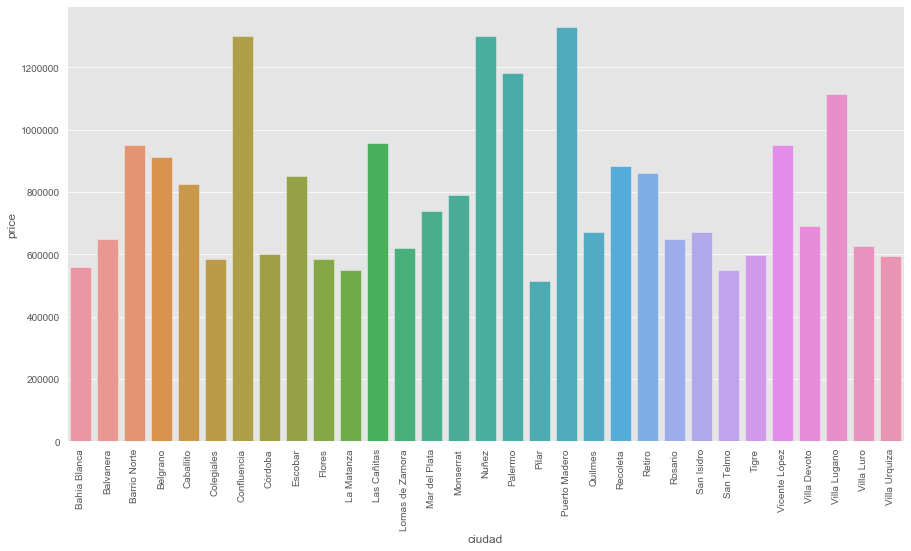

In [154]:
df_arg_expensive=df_argentina[df_argentina['price']>500000]
ciudad_argentina=df_arg_expensive.groupby('ciudad')['price'].mean()
ciudad_argentina=pd.DataFrame(ciudad_argentina).reset_index()
plt.figure(figsize=(15,8))
ax=sns.barplot(x='ciudad',y='price',data=ciudad_argentina)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [155]:
df_argentina['touristic_or_capital']=0
df_test_argentina['touristic_or_capital']=0
categories=['Palermo', 'Belgrano', 'Recoleta', 'Barrio Norte', 'Puerto Madero',
       'Rosario', 'Las Cañitas', 'Nuñez', 'Mar del Plata',
       'Lomas de Zamora', 'Retiro', 'Caballito', 'Villa Devoto',
       'Vicente López', 'Colegiales', 'Villa Urquiza', 'Quilmes',
       'San Telmo', 'Pilar', 'San Isidro', 'Córdoba', 'Confluencia',
       'Tigre', 'La Matanza', 'Bahía Blanca', 'Flores', 'Balvanera',
       'Olavarría', 'Villa Luro', 'Villa Lugano', 'Escobar', 'Monserrat']

for category in categories:
   
    df_argentina.loc[df_argentina['ciudad']==category,'touristic_or_capital']=1
    df_test_argentina.loc[df_test_argentina['ciudad']==category,'touristic_or_capital']=1

In [156]:
df_arg_expensive['ciudad'].unique()

array(['Palermo', 'Belgrano', 'Recoleta', 'Barrio Norte', 'Puerto Madero',
       'Rosario', 'Las Cañitas', 'Nuñez', 'Mar del Plata',
       'Lomas de Zamora', 'Retiro', 'Caballito', 'Villa Devoto',
       'Vicente López', 'Colegiales', 'Villa Urquiza', 'Quilmes',
       'San Telmo', 'Pilar', 'San Isidro', 'Córdoba', 'Confluencia',
       'Tigre', 'La Matanza', 'Bahía Blanca', 'Flores', 'Balvanera',
       'Villa Luro', 'Villa Lugano', 'Escobar', 'Monserrat'], dtype=object)

In [157]:
df_colombia.head(3)

,Id,pais,provincia_departamento,ciudad,property_type,operation_type,rooms,bedrooms,bathrooms,surface_total,...,provincia_departamento_Meta,provincia_departamento_Norte de Santander,provincia_departamento_Quindío,provincia_departamento_Risaralda,provincia_departamento_Santander,provincia_departamento_Tolima,provincia_departamento_Valle del Cauca,social_bathroom,more_than_4_rooms,touristic_or_capital
2,2,Colombia,Atlántico,Barranquilla,Apartamento,Venta,3.0,3.0,3.0,95.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Colombia,Valle del Cauca,Cali,Apartamento,Venta,3.0,3.0,1.0,60.0,...,0,0,0,0,0,0,1,0,0,0
5,5,Colombia,Santander,Floridablanca,Apartamento,Venta,3.0,3.0,2.0,75.0,...,0,0,0,0,1,0,0,0,0,0


((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([ 14.,  18.,  21., ..., 345., 346., 347.])),
 (51.628200364924105, 103.49441149635035, 0.9132217015767892))

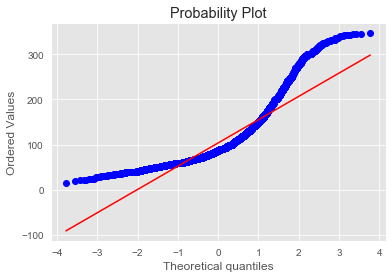

In [158]:
stats.probplot(df_colombia['surface_total'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([ 12.,  12.,  12., ..., 347., 347., 347.])),
 (39.335878747469806, 66.24088325834717, 0.8438713021952852))

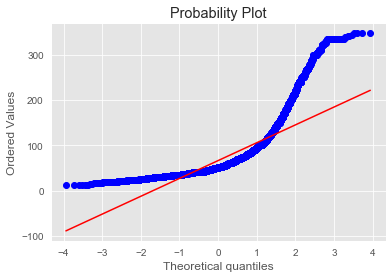

In [167]:
stats.probplot(df_argentina['surface_total'], dist="norm",plot=plt)

In [159]:
surface_total,fitted_lambda_col = stats.boxcox(df_colombia['surface_total'])
box_col=round(fitted_lambda_col,2)
print("Lambda after Box-cox for Colombia is:",box_col)

surface_total,fitted_lambda_arg = stats.boxcox(df_argentina['surface_total'])
box_arg=round(fitted_lambda_arg,2)
print("Lambda after Box-cox for Argentina is:",box_arg)

Lambda after Box-cox for Colombia is: -0.39
Lambda after Box-cox for Argentina is: -0.59


In [160]:
df_colombia['box_surface_total']=boxcox(df_colombia['surface_total'],fitted_lambda_col)
df_argentina['box_surface_total']=boxcox(df_argentina['surface_total'],fitted_lambda_arg)

((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([1.64482171, 1.72993706, 1.7781467 , ..., 2.29390776, 2.29420092,
         2.29449289])),
 (0.07825283233658455, 2.1108410169211105, 0.9961986826437351))

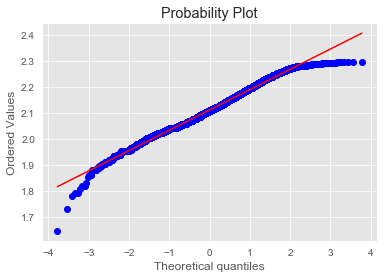

In [161]:
stats.probplot(df_colombia['box_surface_total'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([1.3078734 , 1.3078734 , 1.3078734 , ..., 1.64953372, 1.64953372,
         1.64953372])),
 (0.04601959100887021, 1.5375297994908934, 0.9964901321707859))

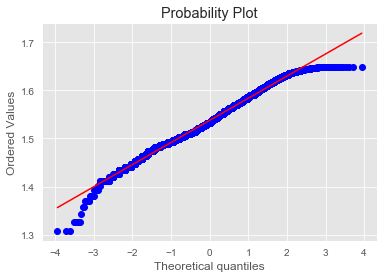

In [168]:
stats.probplot(df_argentina['box_surface_total'], dist="norm",plot=plt)

#### Boxcox to price

((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([   7707.,   13763.,   15139., ..., 1238646., 1252959., 1475365.])),
 (102717.27568264747, 130420.42917427004, 0.8236747311320102))

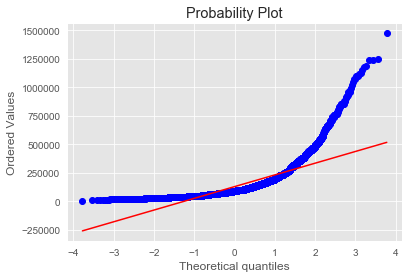

In [169]:
stats.probplot(df_colombia['price'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([   6009.,   10800.,   10900., ..., 3450000., 3450000., 3450000.])),
 (174111.9947446267, 183160.74905280615, 0.6783052107113653))

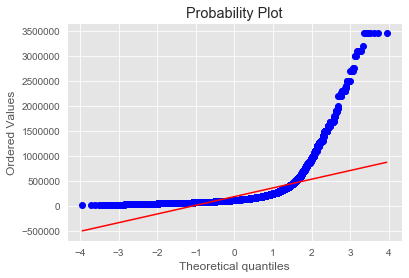

In [170]:
stats.probplot(df_argentina['price'], dist="norm",plot=plt)

In [171]:
price,fitted_lambda_col = stats.boxcox(df_colombia['price'])
box_col=round(fitted_lambda_col,2)
print("Lambda after Box-cox for Colombia is:",box_col)

price,fitted_lambda_arg = stats.boxcox(df_argentina['price'])
box_arg=round(fitted_lambda_arg,2)
print("Lambda after Box-cox for Argentina is:",box_arg)

df_colombia['box_price']=boxcox(df_colombia['price'],fitted_lambda_col)
df_argentina['box_price']=boxcox(df_argentina['price'],fitted_lambda_arg)

Lambda after Box-cox for Colombia is: -0.24
Lambda after Box-cox for Argentina is: -0.41


((array([-3.77798541, -3.55100306, -3.42630245, ...,  3.42630245,
          3.55100306,  3.77798541]),
  array([3.63150666, 3.69212147, 3.70128601, ..., 3.95763684, 3.95800837,
         3.96318076])),
 (0.04225406379344342, 3.840069218062945, 0.998976482051504))

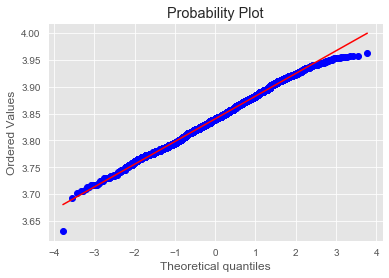

In [172]:
stats.probplot(df_colombia['box_price'], dist="norm",plot=plt)

((array([-3.93828402, -3.72002581, -3.6005055 , ...,  3.6005055 ,
          3.72002581,  3.93828402]),
  array([2.34743942, 2.36157742, 2.36177339, ..., 2.40827104, 2.40827104,
         2.40827104])),
 (0.005189111873788965, 2.393666518763282, 0.9944283644567454))

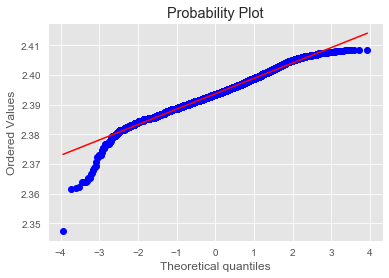

In [173]:
stats.probplot(df_argentina['box_price'], dist="norm",plot=plt)

#### Colombia

In [162]:
df_colombia.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'price',
       'provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'social_bathroom',
       'more_than_4_rooms', 'touristic_or_capital', 'box_surface_total'],
      dtype=object)

In [165]:
predictive_cols=['rooms', 'bathrooms',
       'surface_total', 'provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'social_bathroom',
       'more_than_4_rooms', 'touristic_or_capital']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) #Note:for predictions I should change the test_size to 0.01

In [166]:
xg_reg_col = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

xg_reg_col.fit(x_train,y_train)

preds = xg_reg_col.predict(x_test)

df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
#df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 61929.301162
RMSLE: 0.262767


#### I do the predictions

In [461]:
df_test_colombia['provincia_departamento_Boyacá']=0
df_test_colombia['provincia_departamento_Cauca']=0
df_test_colombia['provincia_departamento_Córdoba']=0
df_test_colombia['provincia_departamento_Huila']=0
df_test_colombia['provincia_departamento_Meta']=0
df_test_colombia['provincia_departamento_Quindío']=0


predictive_cols=['rooms', 'bathrooms',
       'surface_total',  'provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'social_bathroom',
       'more_than_4_rooms', 'touristic_or_capital']

x_test=df_test_colombia[predictive_cols]

In [462]:
df_colombia.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'price',
       'provincia_departamento_Antioquia',
       'provincia_departamento_Atlántico',
       'provincia_departamento_Bolívar', 'provincia_departamento_Boyacá',
       'provincia_departamento_Cauca',
       'provincia_departamento_Cundinamarca',
       'provincia_departamento_Córdoba', 'provincia_departamento_Huila',
       'provincia_departamento_Magdalena', 'provincia_departamento_Meta',
       'provincia_departamento_Norte de Santander',
       'provincia_departamento_Quindío',
       'provincia_departamento_Risaralda',
       'provincia_departamento_Santander',
       'provincia_departamento_Tolima',
       'provincia_departamento_Valle del Cauca', 'social_bathroom',
       'more_than_4_rooms', 'touristic_or_capital'], dtype=object)

In [463]:
predictions=xg_reg_col.predict(x_test)

In [464]:
df_test_colombia['Predictions']=predictions

In [465]:
df_predictions_colombia=df_test_colombia[['Id','Predictions']]
df_predictions_colombia.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Colombia_feature_engineering_all_data.csv',index=None)

#### Argentina

In [466]:
predictive_cols=['rooms', 'bathrooms',
       'surface_total', 'provincia_departamento_Bs.As. G.B.A. Zona Norte',
       'provincia_departamento_Bs.As. G.B.A. Zona Oeste',
       'provincia_departamento_Bs.As. G.B.A. Zona Sur',
       'provincia_departamento_Buenos Aires Costa Atlántica',
       'provincia_departamento_Buenos Aires Interior',
       'provincia_departamento_Capital Federal',
       'provincia_departamento_Chaco', 'provincia_departamento_Chubut',
       'provincia_departamento_Córdoba',
       'provincia_departamento_Entre Ríos',
       'provincia_departamento_Jujuy', 'provincia_departamento_Mendoza',
       'provincia_departamento_Misiones',
       'provincia_departamento_Neuquén',
       'provincia_departamento_Río Negro', 'provincia_departamento_Salta',
       'provincia_departamento_San Juan',
       'provincia_departamento_San Luis',
       'provincia_departamento_Santa Fe',
       'provincia_departamento_Tucumán', 'extra_rooms', 'social_bathroom',
       'touristic_or_capital']

x=df_argentina[predictive_cols]
y=df_argentina['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) #Note:for predictions I should change the test_size to 0.01

In [467]:
df_argentina.columns.values

array(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'currency', 'price',
       'provincia_departamento_Bs.As. G.B.A. Zona Norte',
       'provincia_departamento_Bs.As. G.B.A. Zona Oeste',
       'provincia_departamento_Bs.As. G.B.A. Zona Sur',
       'provincia_departamento_Buenos Aires Costa Atlántica',
       'provincia_departamento_Buenos Aires Interior',
       'provincia_departamento_Capital Federal',
       'provincia_departamento_Chaco', 'provincia_departamento_Chubut',
       'provincia_departamento_Córdoba',
       'provincia_departamento_Entre Ríos',
       'provincia_departamento_Jujuy', 'provincia_departamento_Mendoza',
       'provincia_departamento_Misiones',
       'provincia_departamento_Neuquén',
       'provincia_departamento_Río Negro', 'provincia_departamento_Salta',
       'provincia_departamento_San Juan',
       'provincia_departamento_San Luis',
       'prov

In [468]:
xg_reg_arg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 2, n_estimators = 70,random_state=42)

xg_reg_arg.fit(x_train,y_train)

preds = xg_reg_arg.predict(x_test)

df_pred_cols=pd.DataFrame(preds,columns=["Prediction"])
df_pred_cols['Prediction']=abs(df_pred_cols['Prediction'])

In [469]:
rmse = np.sqrt(mean_squared_error(y_test, df_pred_cols))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,df_pred_cols))
print("RMSLE: %f" % (rmsle))

RMSE: 96832.852216
RMSLE: 0.289476


#### I do the predictions

In [470]:
df_test_argentina['provincia_departamento_Tucumán']=0
df_test_argentina['provincia_departamento_Chaco']=0
df_test_argentina['provincia_departamento_Jujuy']=0
df_test_argentina['provincia_departamento_Chubut']=0

predictive_cols=['rooms', 'bathrooms',
       'surface_total',  'provincia_departamento_Bs.As. G.B.A. Zona Norte',
       'provincia_departamento_Bs.As. G.B.A. Zona Oeste',
       'provincia_departamento_Bs.As. G.B.A. Zona Sur',
       'provincia_departamento_Buenos Aires Costa Atlántica',
       'provincia_departamento_Buenos Aires Interior',
       'provincia_departamento_Capital Federal',
       'provincia_departamento_Chaco', 'provincia_departamento_Chubut',
       'provincia_departamento_Córdoba',
       'provincia_departamento_Entre Ríos',
       'provincia_departamento_Jujuy', 'provincia_departamento_Mendoza',
       'provincia_departamento_Misiones',
       'provincia_departamento_Neuquén',
       'provincia_departamento_Río Negro', 'provincia_departamento_Salta',
       'provincia_departamento_San Juan',
       'provincia_departamento_San Luis',
       'provincia_departamento_Santa Fe',
       'provincia_departamento_Tucumán', 'extra_rooms', 'social_bathroom',
       'touristic_or_capital']

x_test=df_test_argentina[predictive_cols]

In [471]:
predictions=xg_reg_arg.predict(x_test)

In [472]:
df_test_argentina['Predictions']=predictions

In [473]:
df_predictions_argentina=df_test_argentina[['Id','Predictions']]
df_predictions_argentina.to_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\XGBoost_Argentina_feature_engineering_all_data.csv',index=None)

### Model 9.5

In [ ]:
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#df_colombia=df_colombia[(df_colombia['provincia_departamento']=='Cundinamarca') | (df_colombia['provincia_departamento']=='Antioquia')| (df_colombia['provincia_departamento']=='Atlántico')| (df_colombia['provincia_departamento']=='Valle del Cauca')| (df_colombia['provincia_departamento']=='Santander')| (df_colombia['provincia_departamento']=='Risaralda')| (df_colombia['provincia_departamento']=='Tolima')| (df_colombia['provincia_departamento']=='Quindío')| (df_colombia['provincia_departamento']=='Norte de Santander')| (df_colombia['provincia_departamento']=='Bolívar')| (df_colombia['provincia_departamento']=='Magdalena')]
#df_argentina=df_argentina[(df_argentina['provincia_departamento']=='Santa Fe') | (df_argentina['provincia_departamento']=='Capital Federal') | (df_argentina['provincia_departamento']=='Buenos Aires Costa Atlántica') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Norte') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Oeste') | (df_argentina['provincia_departamento']=='Bs.As. G.B.A. Zona Sur') | (df_argentina['provincia_departamento']=='Córdoba') | (df_argentina['provincia_departamento']=='Río Negro') | (df_argentina['provincia_departamento']=='Neuquén') | (df_argentina['provincia_departamento']=='Buenos Aires Interior') | (df_argentina['provincia_departamento']=='Salta') | (df_argentina['provincia_departamento']=='Mendoza') | (df_argentina['provincia_departamento']=='Misiones') | (df_argentina['provincia_departamento']=='Corrientes') | (df_argentina['provincia_departamento']=='San Juan') | (df_argentina['provincia_departamento']=='Entre Ríos') | (df_argentina['provincia_departamento']=='San Luis')]

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

categories=["provincia_departamento"]

for category in categories:
    cat_dummies=pd.get_dummies(df_colombia[category], prefix=category)
    df_train_new=df_colombia.join(cat_dummies)
    df_colombia=df_train_new

    cat_dummies=pd.get_dummies(df_argentina[category], prefix=category)
    df_train_new=df_argentina.join(cat_dummies)
    df_argentina=df_train_new

for category in categories:
    cat_dummies=pd.get_dummies(df_test_colombia[category], prefix=category)
    df_test_new=df_test_colombia.join(cat_dummies)
    df_test_colombia=df_test_new

    cat_dummies=pd.get_dummies(df_test_argentina[category], prefix=category)
    df_test_new=df_test_argentina.join(cat_dummies)
    df_test_argentina=df_test_new

In [ ]:
df_argentina['extra_rooms']=df_argentina['rooms']-df_argentina['bedrooms']
df_test_argentina['extra_rooms']=df_test_argentina['rooms']-df_test_argentina['bedrooms']

In [ ]:
df_colombia['social_bathroom']=((df_colombia['bathrooms']-df_colombia['rooms'])>=1).astype(int)
df_test_colombia['social_bathroom']=((df_test_colombia['bathrooms']-df_test_colombia['rooms'])>=1).astype(int)

df_argentina['social_bathroom']=((df_argentina['bathrooms']-df_argentina['rooms'])>=1).astype(int)
df_test_argentina['social_bathroom']=((df_test_argentina['bathrooms']-df_test_argentina['rooms'])>=1).astype(int)

In [ ]:
df_colombia['more_than_4_rooms']=(df_colombia['rooms']>4).astype(int)
df_test_colombia['more_than_4_rooms']=(df_colombia['rooms']>4).astype(int)

In [ ]:
df_colombia['touristic_or_capital']=0
df_colombia.loc[df_colombia['ciudad']=="Cartagena",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Santa Marta",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Bogotá D.C",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="La Calera",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Retiro",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Cabrera",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Agua de Dios",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Envigado",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Juan de Acosta",'touristic_or_capital']=1
df_colombia.loc[df_colombia['ciudad']=="Medellín",'touristic_or_capital']=1

df_test_colombia['touristic_or_capital']=0
df_test_colombia.loc[df_test_colombia['ciudad']=="Cartagena",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Santa Marta",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Bogotá D.C",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="La Calera",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Retiro",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Cabrera",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Agua de Dios",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Envigado",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Juan de Acosta",'touristic_or_capital']=1
df_test_colombia.loc[df_test_colombia['ciudad']=="Medellín",'touristic_or_capital']=1

In [ ]:
df_argentina['touristic_or_capital']=0
df_test_argentina['touristic_or_capital']=0
categories=['Palermo', 'Belgrano', 'Recoleta', 'Barrio Norte', 'Puerto Madero',
       'Rosario', 'Las Cañitas', 'Nuñez', 'Mar del Plata',
       'Lomas de Zamora', 'Retiro', 'Caballito', 'Villa Devoto',
       'Vicente López', 'Colegiales', 'Villa Urquiza', 'Quilmes',
       'San Telmo', 'Pilar', 'San Isidro', 'Córdoba', 'Confluencia',
       'Tigre', 'La Matanza', 'Bahía Blanca', 'Flores', 'Balvanera',
       'Olavarría', 'Villa Luro', 'Villa Lugano', 'Escobar', 'Monserrat']

for category in categories:
   
    df_argentina.loc[df_argentina['ciudad']==category,'touristic_or_capital']=1
    df_test_argentina.loc[df_test_argentina['ciudad']==category,'touristic_or_capital']=1

In [ ]:
stats.probplot(df_colombia['surface_total'], dist="norm",plot=plt)

In [ ]:
surface_total,fitted_lambda_col = stats.boxcox(df_colombia['surface_total'])
box_col=round(fitted_lambda_col,2)
print("Lambda after Box-cox for Colombia is:",box_col)

surface_total,fitted_lambda_arg = stats.boxcox(df_argentina['surface_total'])
box_arg=round(fitted_lambda_arg,2)
print("Lambda after Box-cox for Argentina is:",box_arg)

In [ ]:
df_colombia['box_surface_total']=boxcox(df_colombia['surface_total'],fitted_lambda_col)
df_argentina['box_surface_total']=boxcox(df_argentina['surface_total'],fitted_lambda_arg)

In [ ]:
stats.probplot(df_argentina['box_surface_total'], dist="norm",plot=plt)

#### Calculate VIF

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [103]:
df_vif=df_colombia[['rooms','bathrooms','surface_total','social_bathroom']]

In [104]:
calc_vif(df_vif)

,variables,VIF
0,rooms,18.837172
1,bathrooms,31.960591
2,surface_total,9.437727
3,social_bathroom,2.895855


In [107]:
df_vif=df_colombia[['rooms','surface_total','social_bathroom']]
calc_vif(df_vif)

,variables,VIF
0,rooms,6.035425
1,surface_total,7.214157
2,social_bathroom,1.515693


### Model 10 - Ridge Regression

In [24]:
#read and separate the df
df=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Train.csv')
df_test=pd.read_csv(r'C:\Users\feche\Documents\Curso Python\datasets\Apartamentos-latam\Test.csv')

df_colombia=df[df['pais']=='Colombia']
df_argentina=df[df['pais']=='Argentina']

df_test_colombia=df_test[df_test['pais']=='Colombia']
df_test_argentina=df_test[df_test['pais']=='Argentina']

#Correciones de precios mal puestos
df_colombia.loc[16166,'price']=233966
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
#Dummies
cat_dummies=pd.get_dummies(df_colombia["provincia_departamento"], prefix="departamento")
df_train_new=df_colombia.join(cat_dummies)
df_colombia=df_train_new
    
cat_dummies=pd.get_dummies(df_argentina["provincia_departamento"], prefix="departamento")
df_train_new=df_argentina.join(cat_dummies)
df_argentina=df_train_new

cat_dummies=pd.get_dummies(df_test_colombia["provincia_departamento"], prefix="departamento")
df_test_new=df_test_colombia.join(cat_dummies)
df_test_colombia=df_test_new
    
cat_dummies=pd.get_dummies(df_test_argentina["provincia_departamento"], prefix="departamento")
df_test_new=df_test_argentina.join(cat_dummies)
df_test_argentina=df_test_new

In [26]:
df_colombia['log_price']=np.log(df_colombia['price'])
df_argentina['log_price']=np.log(df_colombia['price'])

#### Colombia

In [27]:
predictive_cols=['rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'departamento_Antioquia',
       'departamento_Atlántico', 'departamento_Bolívar',
       'departamento_Boyacá', 'departamento_Cauca',
       'departamento_Cundinamarca', 'departamento_Córdoba',
       'departamento_Huila', 'departamento_Magdalena',
       'departamento_Meta', 'departamento_Norte de Santander',
       'departamento_Quindío', 'departamento_Risaralda',
       'departamento_Santander', 'departamento_Tolima',
       'departamento_Valle del Cauca']

x=df_colombia[predictive_cols]
y=df_colombia['price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
from sklearn.linear_model import Ridge

In [29]:
ridge=Ridge()
ridge.fit(x_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
ridge.score(x_test,y_test)

0.7113497275036484

In [32]:
preds=(ridge.predict(x_test))
preds=abs(preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,preds))
print("RMSLE: %f" % (rmsle))

RMSE: 72143.920162
RMSLE: 0.620152


In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
parameters={"alpha":[0,1e-5,0,0.5,1,2,20]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring="neg_mean_squared_error",cv=10)
ridge_regressor.fit(x_train,y_train)

C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.22437e-21): result may not be accurate.
  overwrite_a=True).T
C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.32434e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.8048e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.41009e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.22437e-21): result may not be accurate.
  overwrite_a=True).T
C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_mod

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 1e-05, 0, 0.5, 1, 2, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [78]:
ridge_regressor.best_params_

{'alpha': 0.5}

In [93]:
from sklearn.linear_model import Lasso

In [94]:
lasso=Lasso()
lasso.fit(x_train,y_train)

C:\Users\feche\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3390153322896.705, tolerance: 10978272237.402006
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [95]:
lasso.score(x_test,y_test)

0.6901149083479494

In [98]:
preds=lasso.predict(x_test)
preds=abs(preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

rmsle=np.sqrt(mean_squared_log_error(y_test,preds))
print("RMSLE: %f" % (rmsle))

RMSE: 75441.478245
RMSLE: 0.640764


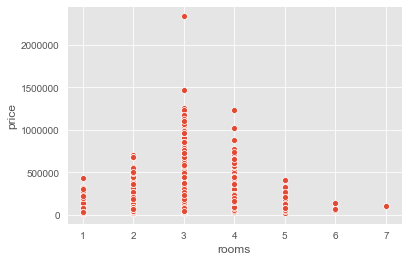

In [5]:
sns.scatterplot(x='rooms',y='price',data=df_colombia)

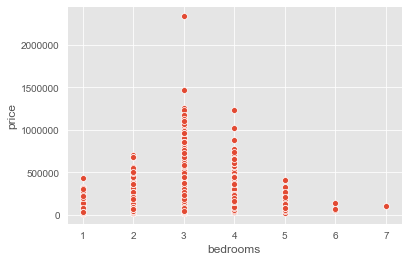

In [6]:
sns.scatterplot(x='bedrooms',y='price',data=df_colombia)

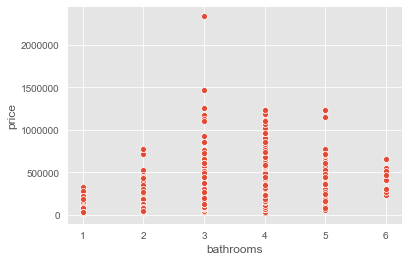

In [7]:
sns.scatterplot(x='bathrooms',y='price',data=df_colombia)

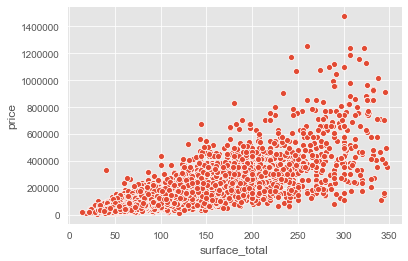

In [60]:
sns.scatterplot(x='surface_total',y='price',data=df_colombia)

In [61]:
df_colombia[(df_colombia['price']>200000) & (df_colombia['surface_total']<50)]

,Id,pais,provincia_departamento,ciudad,property_type,operation_type,rooms,bedrooms,bathrooms,surface_total,currency,price
2196,2196,Colombia,Valle del Cauca,Cali,Apartamento,Venta,1.0,1.0,1.0,40.0,USD,330306.0


In [59]:
df_colombia.loc[16166,'price']=233966
df_colombia.loc[9093,'price']=71566
df_colombia.loc[12408,'price']=63297
df_colombia.loc[12408,'surface_total']=100
df_colombia.loc[25309,'price']=72942

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


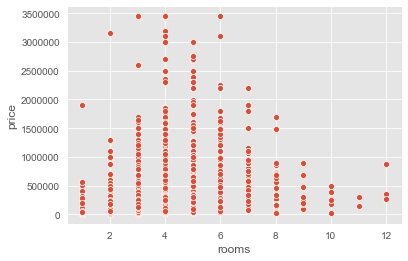

In [10]:
sns.scatterplot(x='rooms',y='price',data=df_argentina)

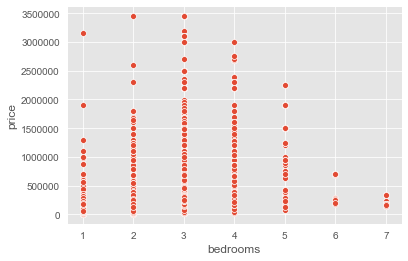

In [11]:
sns.scatterplot(x='bedrooms',y='price',data=df_argentina)

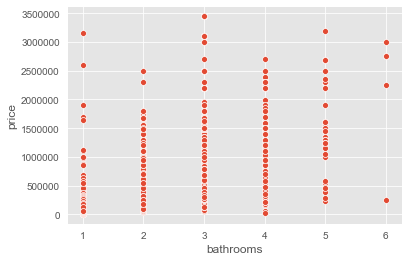

In [12]:
sns.scatterplot(x='bathrooms',y='price',data=df_argentina)

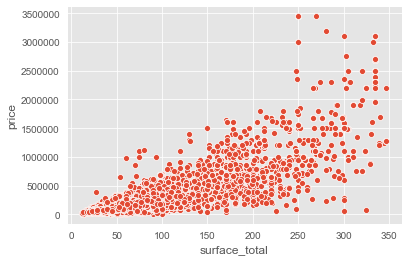

In [26]:
sns.scatterplot(x='surface_total',y='price',data=df_argentina)

In [24]:
df_argentina[(df_argentina['price']>1500000) & (df_argentina['surface_total']<100)]

,Id,pais,provincia_departamento,ciudad,property_type,operation_type,rooms,bedrooms,bathrooms,surface_total,currency,price
14865,14865,Argentina,Santa Fe,Rosario,Departamento,Venta,1.0,1.0,1.0,32.0,USD,1900000.0
16720,16720,Argentina,Santa Fe,Rosario,Departamento,Venta,3.0,2.0,1.0,73.0,USD,1700000.0
21378,21378,Argentina,Buenos Aires Interior,Olavarría,Departamento,Venta,3.0,2.0,1.0,50.0,USD,1650000.0


In [25]:
df_argentina.loc[24084,'price']=315000
df_argentina.loc[20385,'price']=260000
df_argentina.loc[14865,'price']=190000
df_argentina.loc[16720,'price']=170000
df_argentina.loc[21378,'price']=165000

C:\Users\feche\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
